In [2]:
require(data.table)
require(dplyr)
require(tidyverse)
require(dada2)
require(phyloseq)
require(genefilter)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)

Loading required package: dada2

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘dada2’”


In [3]:
ps<-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps_final.rds")
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

In [4]:
#normalizing ps by converting rawcounts into relative abundances
#so samples with more reads wont be over represented
#using ps bc only to the count data (OTU table), while preserving the rest of the object
ps_norm = transform_sample_counts(ps, function(x) 1E6 * x / sum(x))

In [5]:
#isolate just bacteria
ps_norm_bac=subset_taxa(ps_norm, Kingdom=="Bacteria")
ps_norm_bac

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 82622 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 82622 taxa by 6 taxonomic ranks ]

In [6]:
#remove chloroplast order
ps_norm_nochlo=subset_taxa(ps_norm_bac, Order!="Chloroplast")
ps_norm_nochlo

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 60602 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 60602 taxa by 6 taxonomic ranks ]

In [7]:
theme_set(theme_bw())

### plot no chloroplast using glom

comparing Date_16S

In [8]:
ps_norm_nochlo_glom=tax_glom(ps_norm_nochlo, taxrank="Order")

In [9]:
top10 <- names(sort(taxa_sums(ps_norm_nochlo_glom), decreasing=TRUE))[1:10] 
#ps.top20 <- transform_sample_counts(ps_norm, function(OTU) OTU/sum(OTU)) 
ps_norm_nochlo_glom_top10 <- prune_taxa(top10, ps_norm_nochlo_glom) 

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the phyloseq package.
  Please report the issue at <https://github.com/joey711/phyloseq/issues>.”


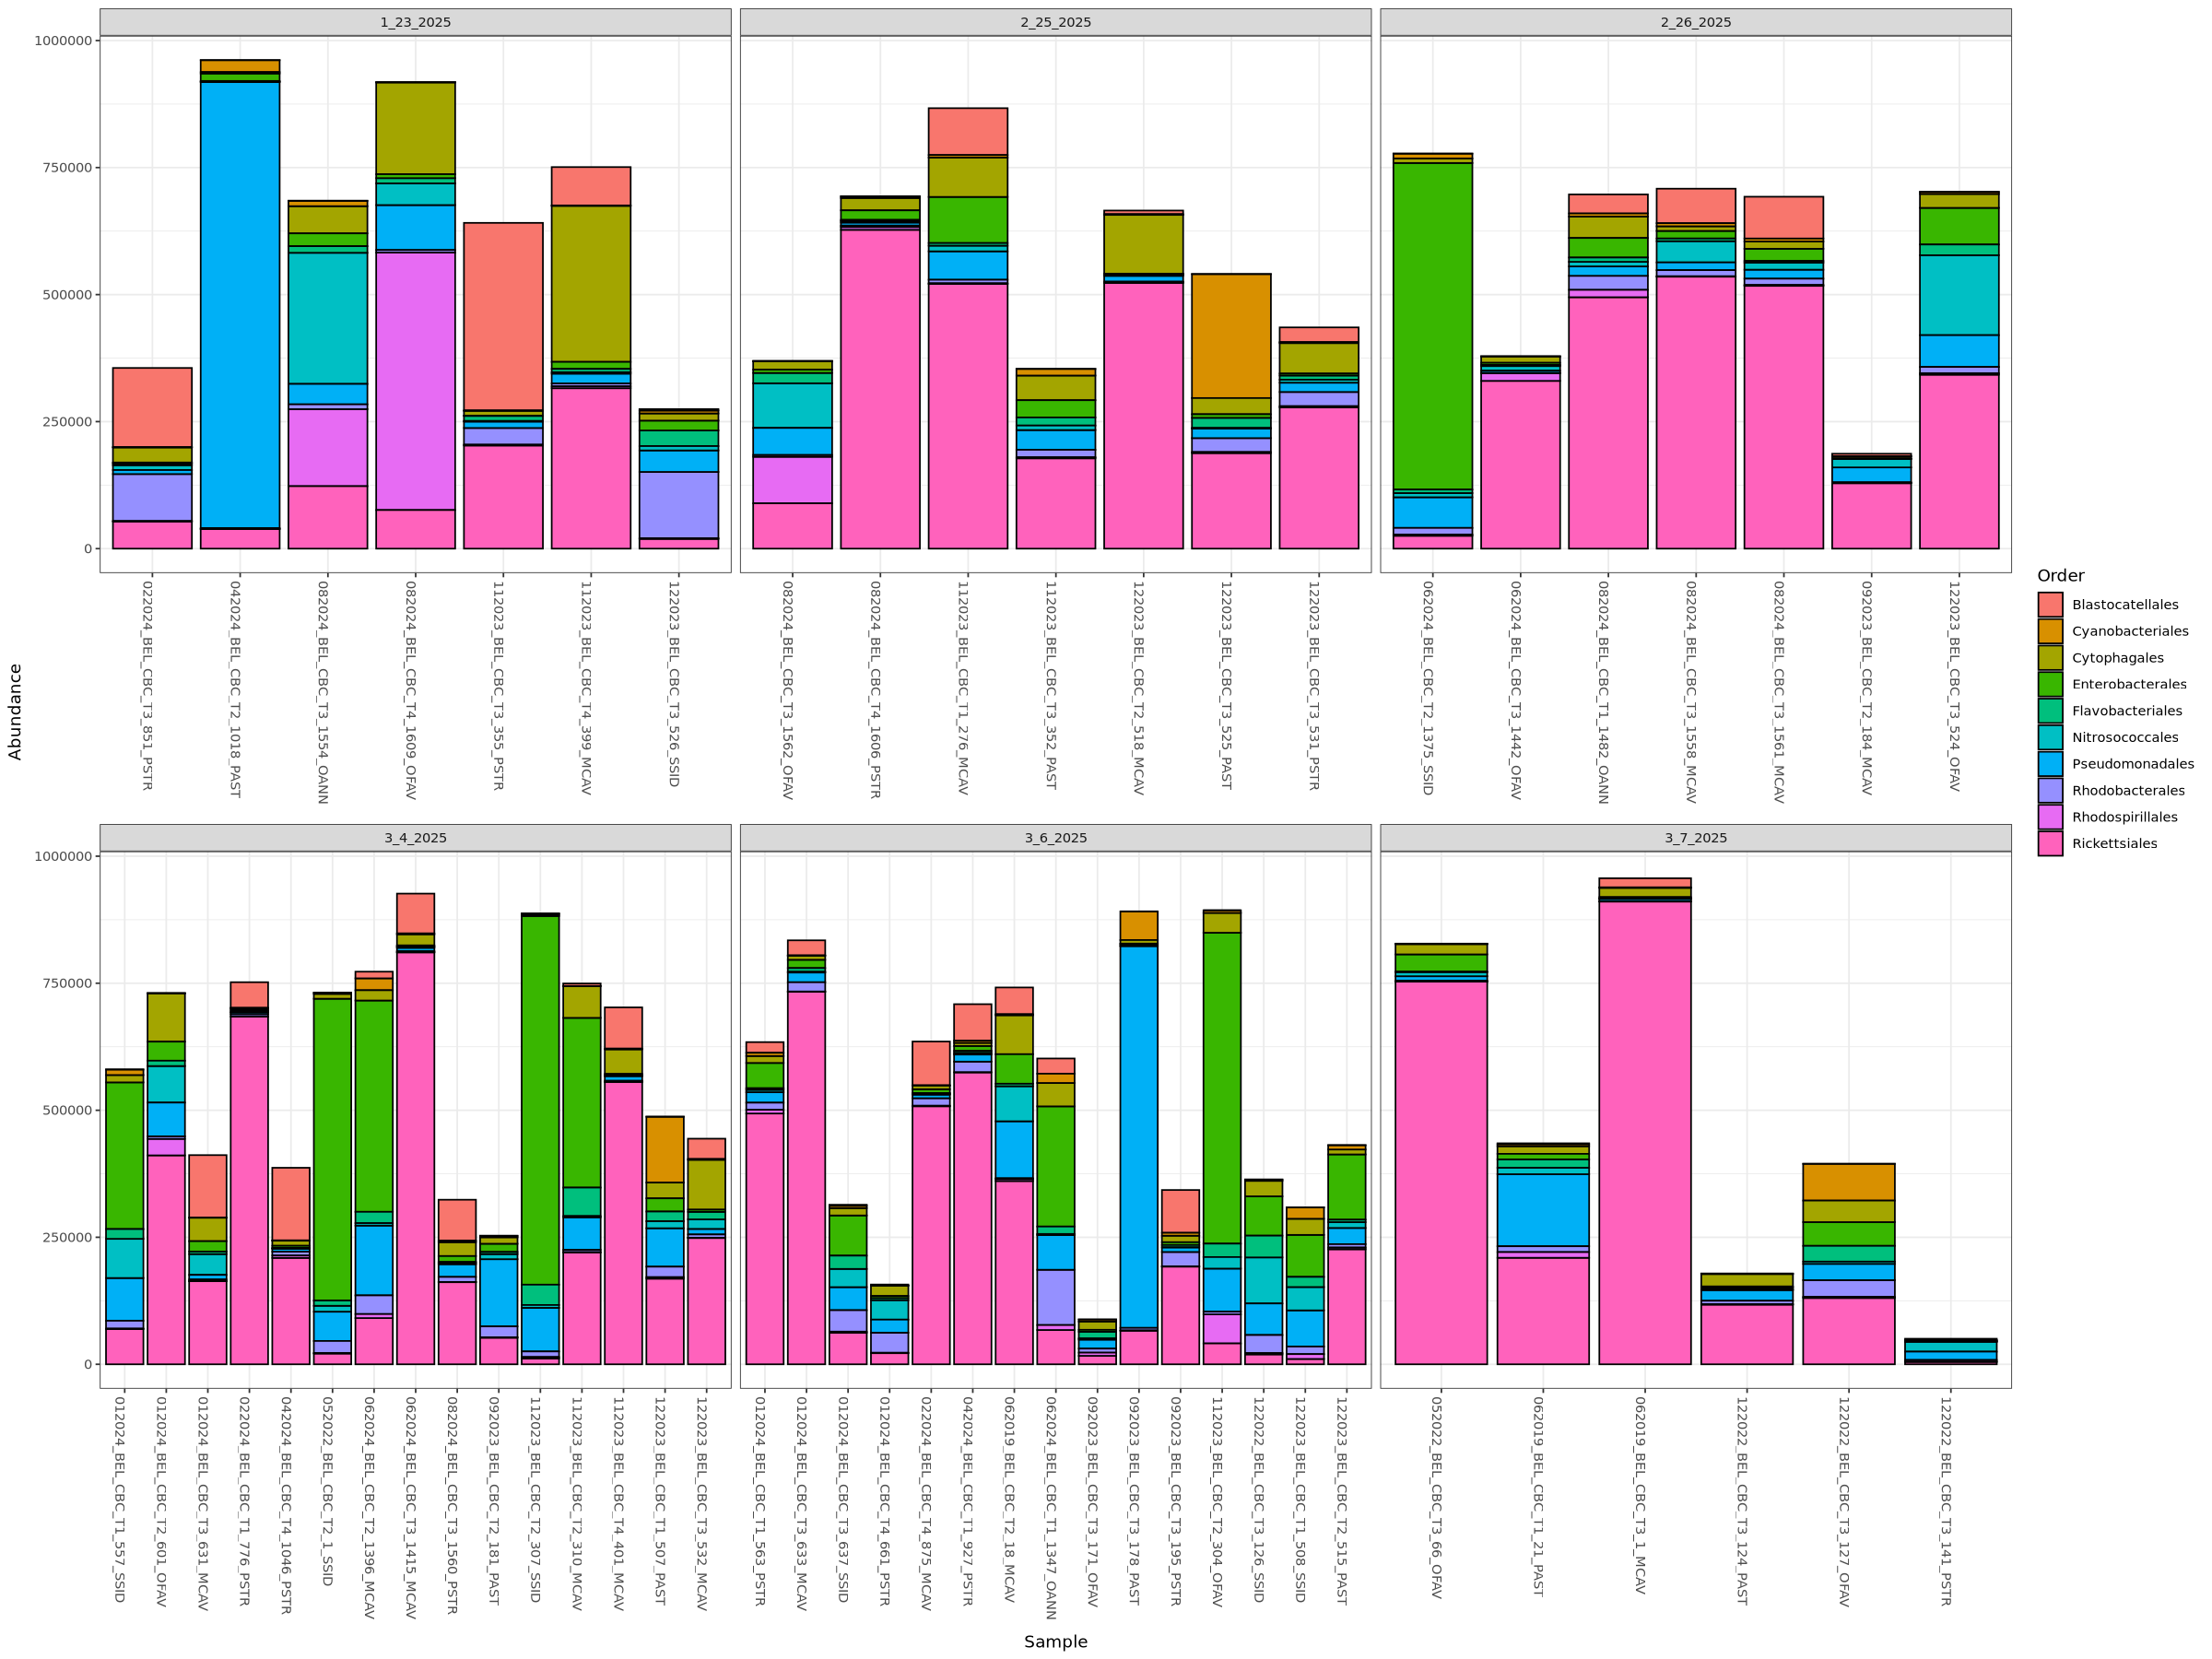

In [10]:
plot_bar(ps_norm_nochlo_glom_top10, fill="Order")+ facet_wrap(~Date_16S, scales="free_x")

### plot no chloroplast without glom
comparing species

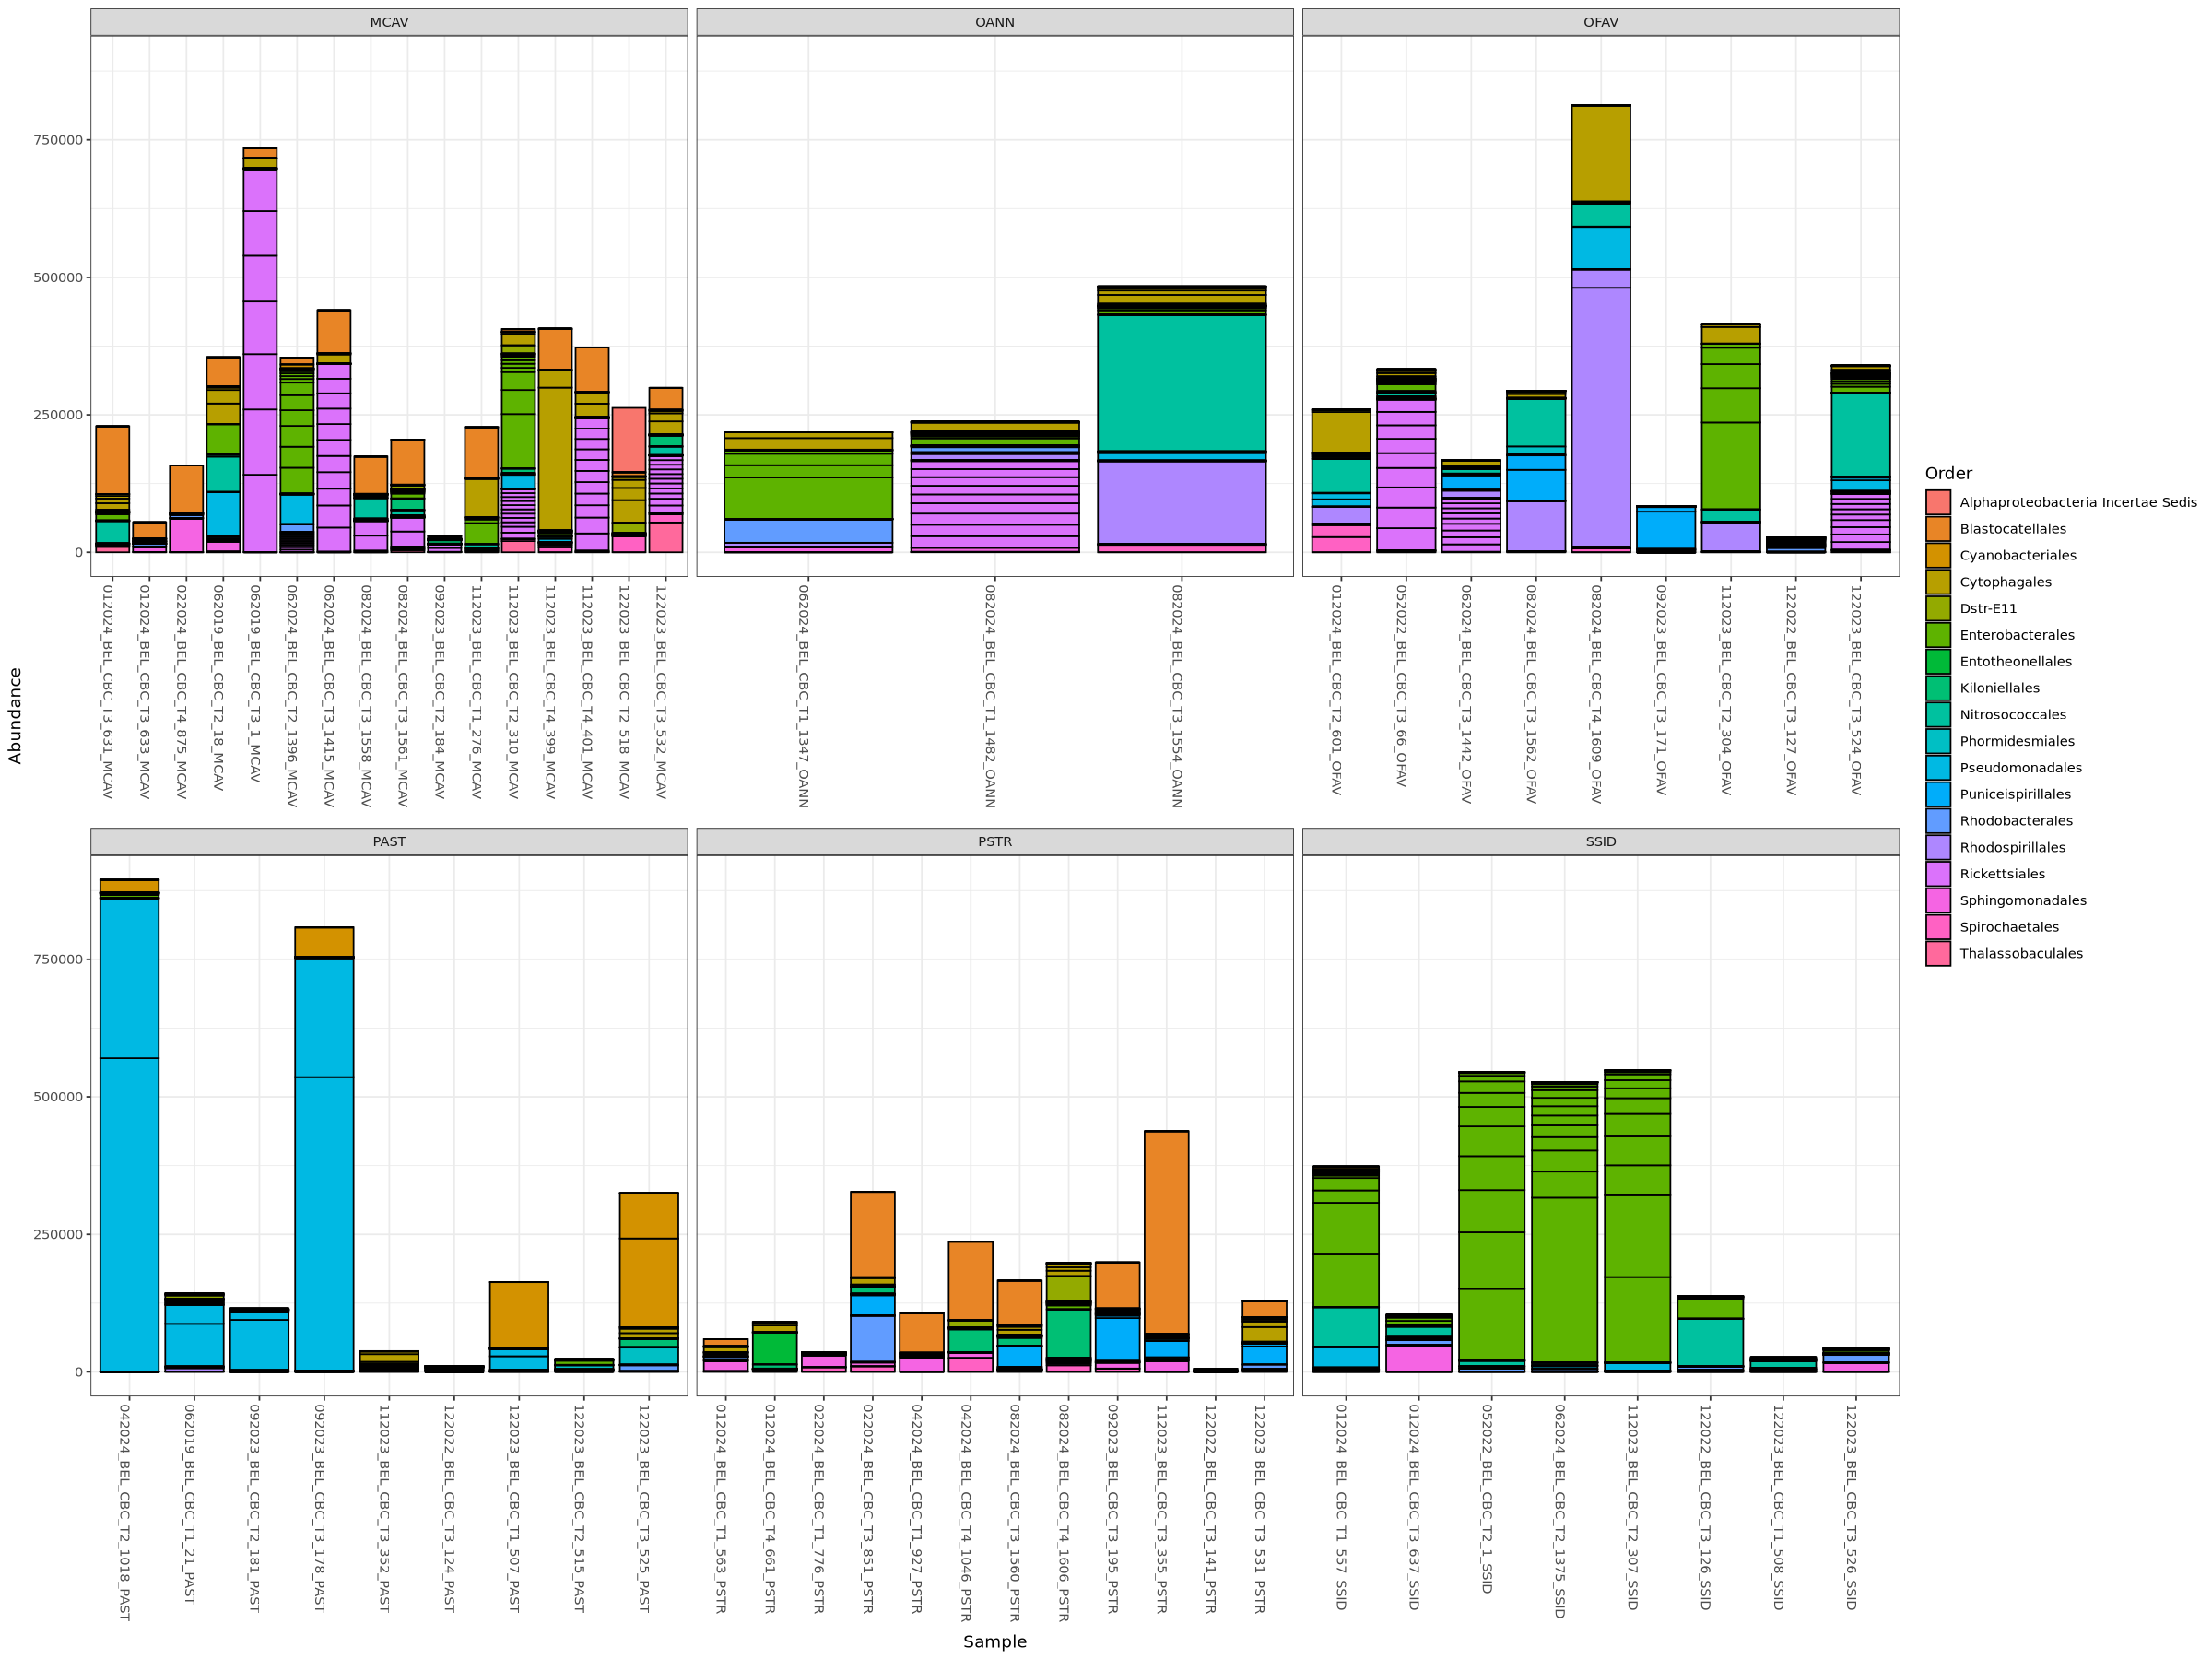

In [11]:
#plot after removing chloroplast
top100 <- names(sort(taxa_sums(ps_norm_nochlo), decreasing=TRUE))[1:100] 
#ps.top20 <- transform_sample_counts(ps_norm, function(OTU) OTU/sum(OTU)) 
ps.top100 <- prune_taxa(top100, ps_norm_nochlo) 
plot_bar(ps.top100, fill="Order") + facet_wrap(~species, scales="free_x")

### remove mitochondria, I think is being overrep in MCAV and OANN family level

In [8]:
#remove mitochondria family
ps_norm_nomit=subset_taxa(ps_norm_nochlo, Family!="Mitochondria")
ps_norm_nomit

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 44554 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 44554 taxa by 6 taxonomic ranks ]

In [ ]:
plot_bar(ps_norm_nomit, fill="Phylum")+
geom_bar(aes(color=Phylum, fill=Phylum), stat="identity", position="stack")

#### some have abundances of 750,000, some have abundances of 100k

In [9]:
#sizing plots
options(repr.plot.width=30, repr.plot.height=18)

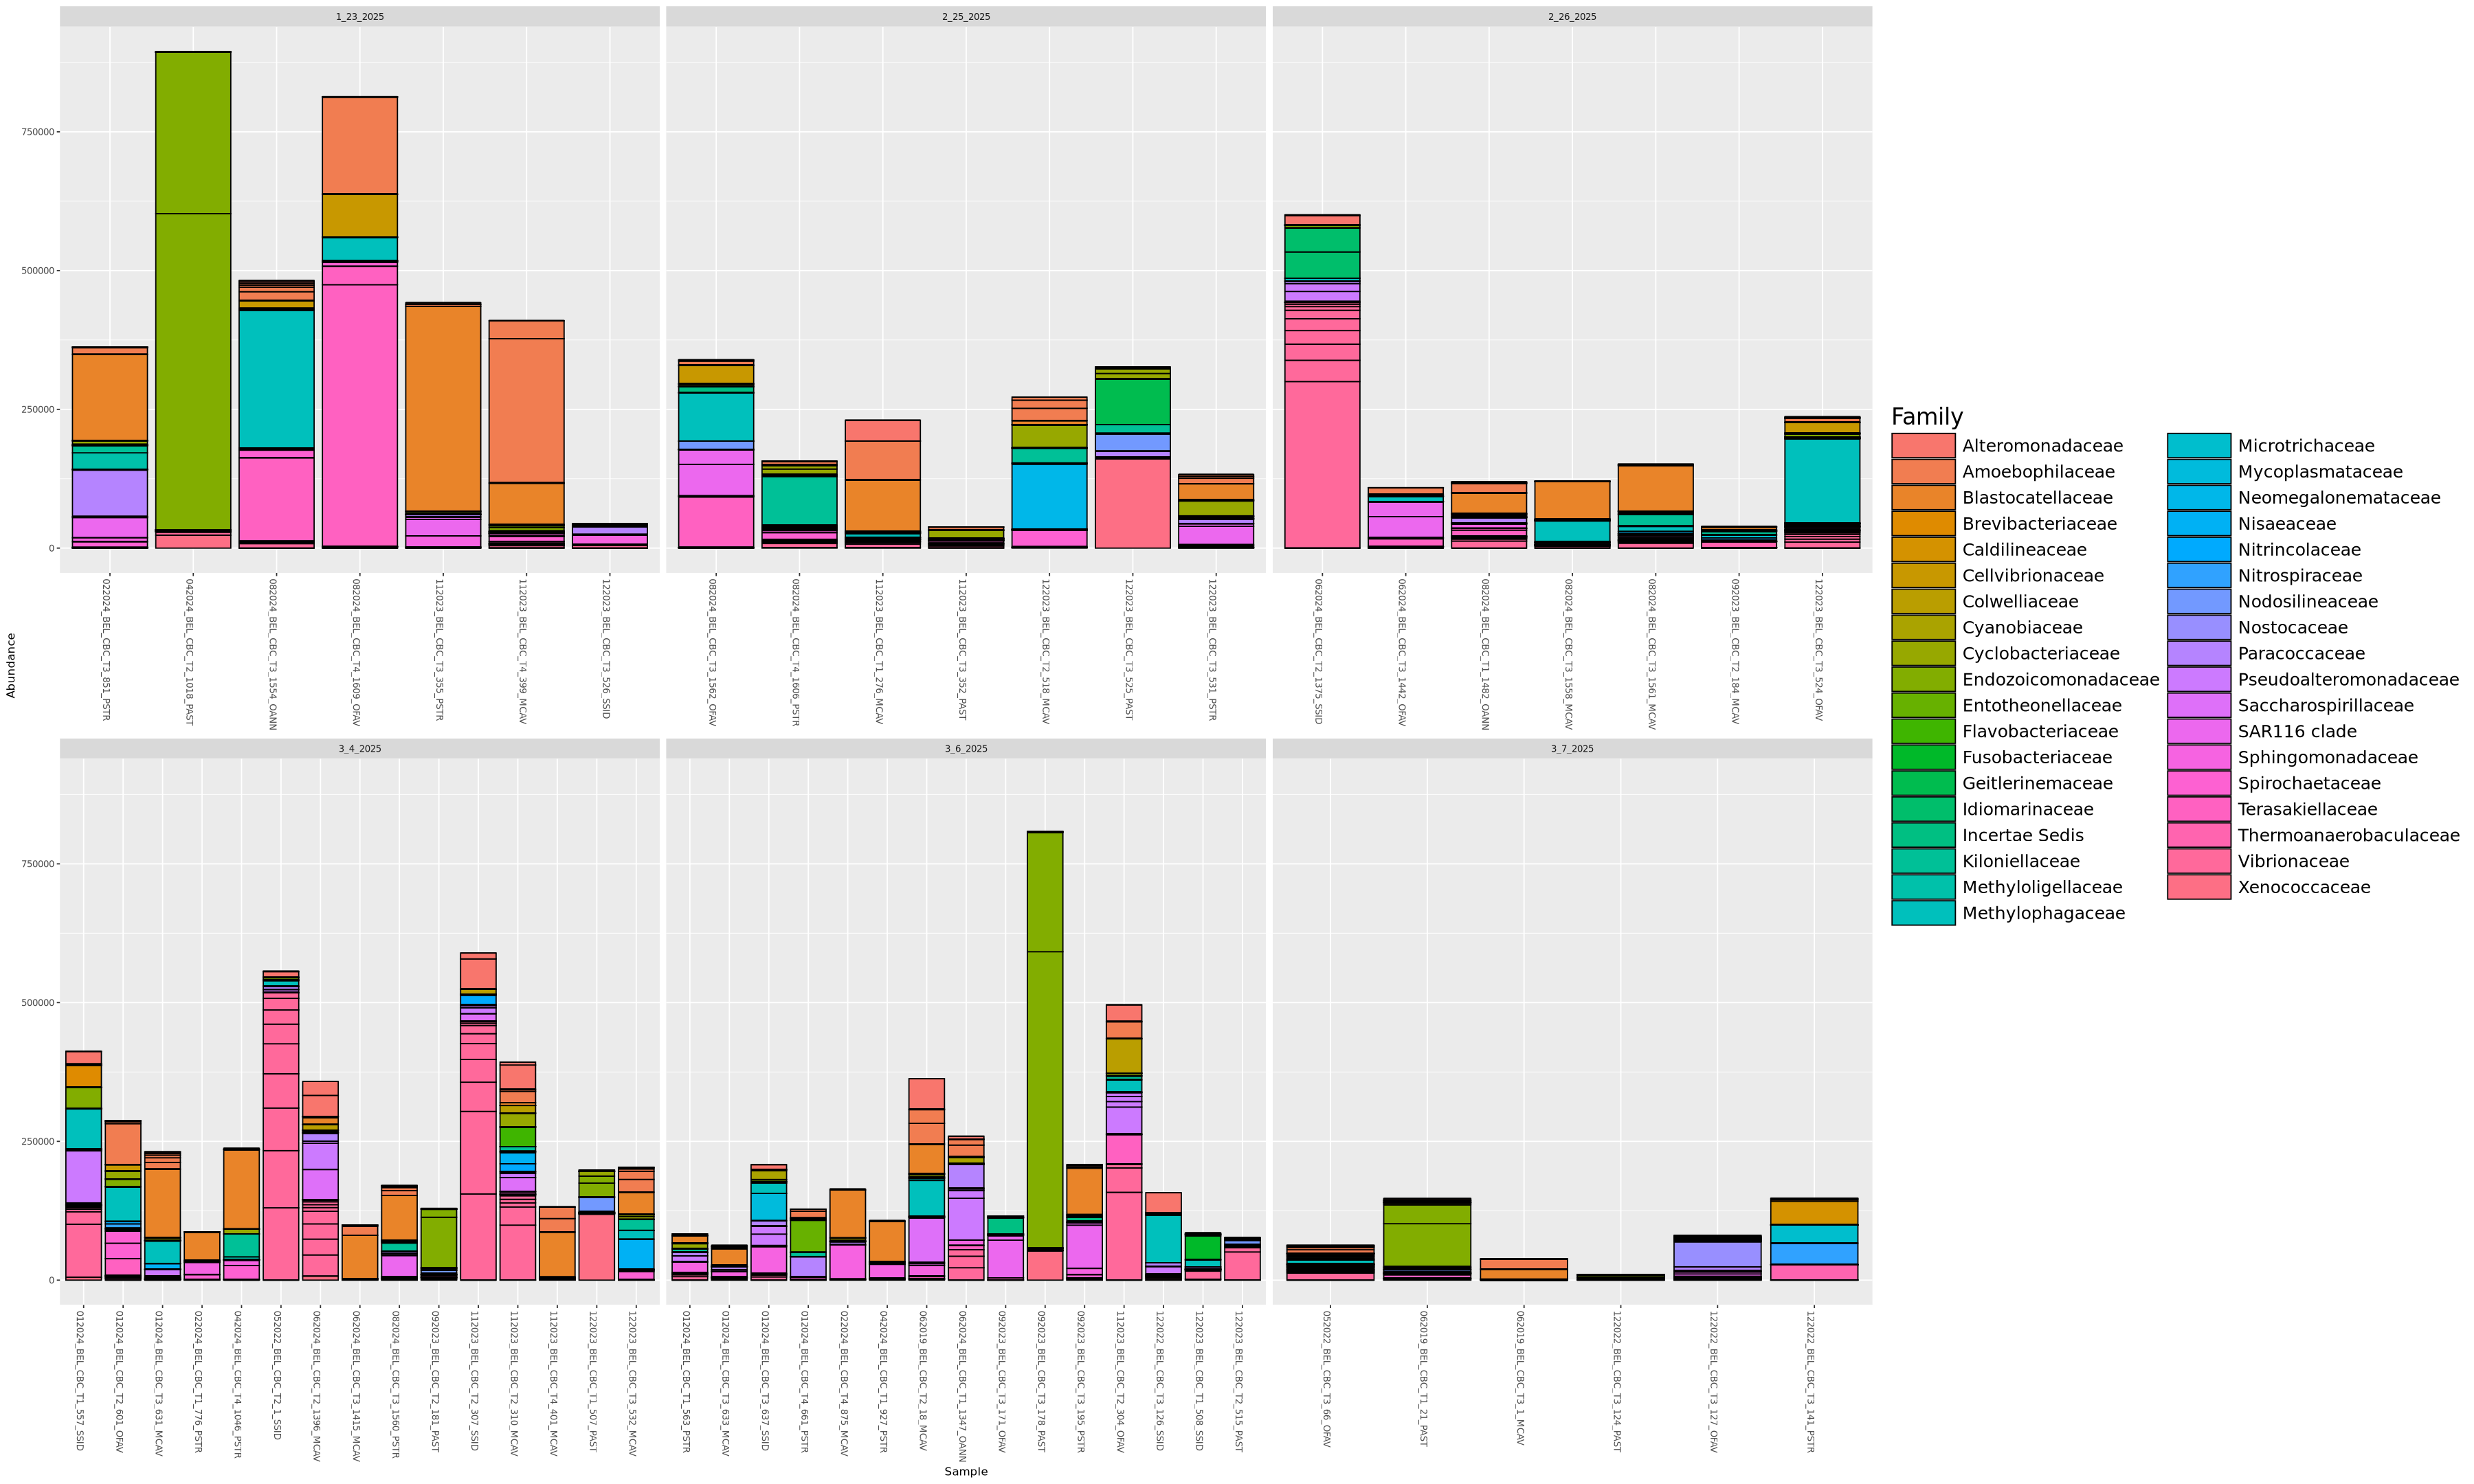

In [12]:
#plot after removing chloroplast
top100_nomit <- names(sort(taxa_sums(ps_norm_nomit), decreasing=TRUE))[1:100] 
#ps.top20 <- transform_sample_counts(ps_norm, function(OTU) OTU/sum(OTU)) 
ps.top100_nomit <- prune_taxa(top100_nomit, ps_norm_nomit) 
plot_bar(ps.top100_nomit, fill="Family") + 
theme(
  legend.position = "right", 
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  text = element_text(size = 10),
  legend.key.width = unit(2, "cm"),     # make the legend keys wider
  legend.key.height = unit(0.8, "cm")   # make them taller
) +
guides(color = guide_legend(override.aes = list(size = 8)))+
facet_wrap(~Date_16S, scales="free_x") 

### great now test this but separate by colony

#### clean up colony

In [9]:
# convert the sample_data() within a phyloseq object to a vegan compatible data object
pssd2veg <- function(ps_norm_nomit) {
  sd_nomit <- sample_data(ps_norm_nomit)
  return(as(sd_nomit,"data.frame"))
}
#using phyloseq nmds plot no chloroplast
sample_nomit <- pssd2veg(ps_norm_nomit)

In [10]:
sample_nomit <- as.data.frame(sample_data(ps_norm_nomit))
#save sammple names as a column so tidy doesn't get rid of it during filtering
sample_nomit$SampleID <- rownames(sample_nomit)

In [11]:
# Return names which have more than one row of data
# Now filter
sample_clean <- sample_nomit %>%
  group_by(colony) %>%
  filter(n() != 1) %>%
  ungroup()

In [12]:
nrow(sample_nomit)
nrow(sample_clean)

[1] 57

[1] 42

In [13]:
sample_clean <- as.data.frame(sample_clean)
class(sample_clean)

Warning message in class(x) <- tibble_class:
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”


[1] "data.frame"

#### make dates be in chronological order

In [14]:
# 1. create proper Date variable
sample_clean$MonthYearDate <- as.Date(
  paste0("01 ", sample_clean$MonthYear),
  format = "%d %b %Y"
)

# 2. reorder MonthYear as a factor in chronological order
sample_clean$MonthYear <- factor(
  sample_clean$MonthYear,
  levels = unique(sample_clean$MonthYear[order(sample_clean$MonthYearDate)])
)


In [15]:
# Restore rownames
rownames(sample_clean) <- sample_clean$SampleID

In [16]:
head(rownames(sample_clean))
NROW(sample_names(ps_norm_nomit))

[1] "012024_BEL_CBC_T1_557_SSID" "012024_BEL_CBC_T1_563_PSTR"
[3] "012024_BEL_CBC_T3_631_MCAV" "012024_BEL_CBC_T3_633_MCAV"
[5] "012024_BEL_CBC_T3_637_SSID" "012024_BEL_CBC_T4_661_PSTR"

[1] 57

In [17]:
keep_samples <- rownames(sample_clean)
length(keep_samples)
#how many of the values in keep_samples exist in ps_norm_nomit
sum(keep_samples %in% sample_names(ps_norm_nomit))  # Should be 42

[1] 42

[1] 42

In [18]:
# Prune to keep only those samples
ps_clean <- prune_samples(sample_names(ps_norm_nomit) %in% keep_samples, ps_norm_nomit)

In [19]:
class(ps_clean)

[1] "phyloseq"
attr(,"package")
[1] "phyloseq"

In [20]:
nrow(sample_data(ps_clean))

[1] 42

In [21]:
all(rownames(sample_clean) %in% sample_names(ps_clean))

[1] TRUE

In [22]:
#take the filtered metadata I just worked on — with cleaned rows, and correct sample names — and replace the old sample data in ps_clean with this cleaned version
sd_clean <- phyloseq::sample_data(sample_clean)
sample_data(ps_clean) <- sd_clean
head(sample_data(ps_clean))

Health_Status colony Date_16S double_band
012024_BEL_CBC_T1_557_SSID Healthy       1_3    3_4_2025 y          
012024_BEL_CBC_T1_563_PSTR Healthy       1_12   3_6_2025            
012024_BEL_CBC_T3_631_MCAV Healthy       3_21   3_4_2025            
012024_BEL_CBC_T3_633_MCAV Healthy       3_2    3_6_2025            
012024_BEL_CBC_T3_637_SSID Healthy       3_5    3_6_2025            
012024_BEL_CBC_T4_661_PSTR Healthy       4_98   3_6_2025 y          
                           date_sampled transect species MonthYear
012024_BEL_CBC_T1_557_SSID 012024       T1       SSID    Jan 2024 
012024_BEL_CBC_T1_563_PSTR 012024       T1       PSTR    Jan 2024 
012024_BEL_CBC_T3_631_MCAV 012024       T3       MCAV    Jan 2024 
012024_BEL_CBC_T3_633_MCAV 012024       T3       MCAV    Jan 2024 
012024_BEL_CBC_T3_637_SSID 012024       T3       SSID    Jan 2024 
012024_BEL_CBC_T4_661_PSTR 012024       T4       PSTR    Jan 2024 
                           TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG
012024_BEL_CBC_T1_557_SSID 580                                                                                                                                                                                                                                                          
012024_BEL_CBC_T1_563_PSTR   0                                                                                                                                                                                                                                                          
012024_BEL_CBC_T3_631_MCAV 328                                                                                                                                                                                                                                                          
012024_BEL_CBC_T3_633_MCAV   0                                                                                                                                                                                                                                                          
012024_BEL_CBC_T3_637_SSID   0                                                                                                                                                                                                                                                          
012024_BEL_CBC_T4_661_PSTR   0                                                                                                                                                                                                                                                          
                           ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA
012024_BEL_CBC_T1_557_SSID   0                                                                                                                                                                                                                                                            
012024_BEL_CBC_T1_563_PSTR   0                                                                                                                                                                                                                                                            
012024_BEL_CBC_T3_631_MCAV   0                                                                                                                                                                                                                                     

#### testing color and style of colony plot

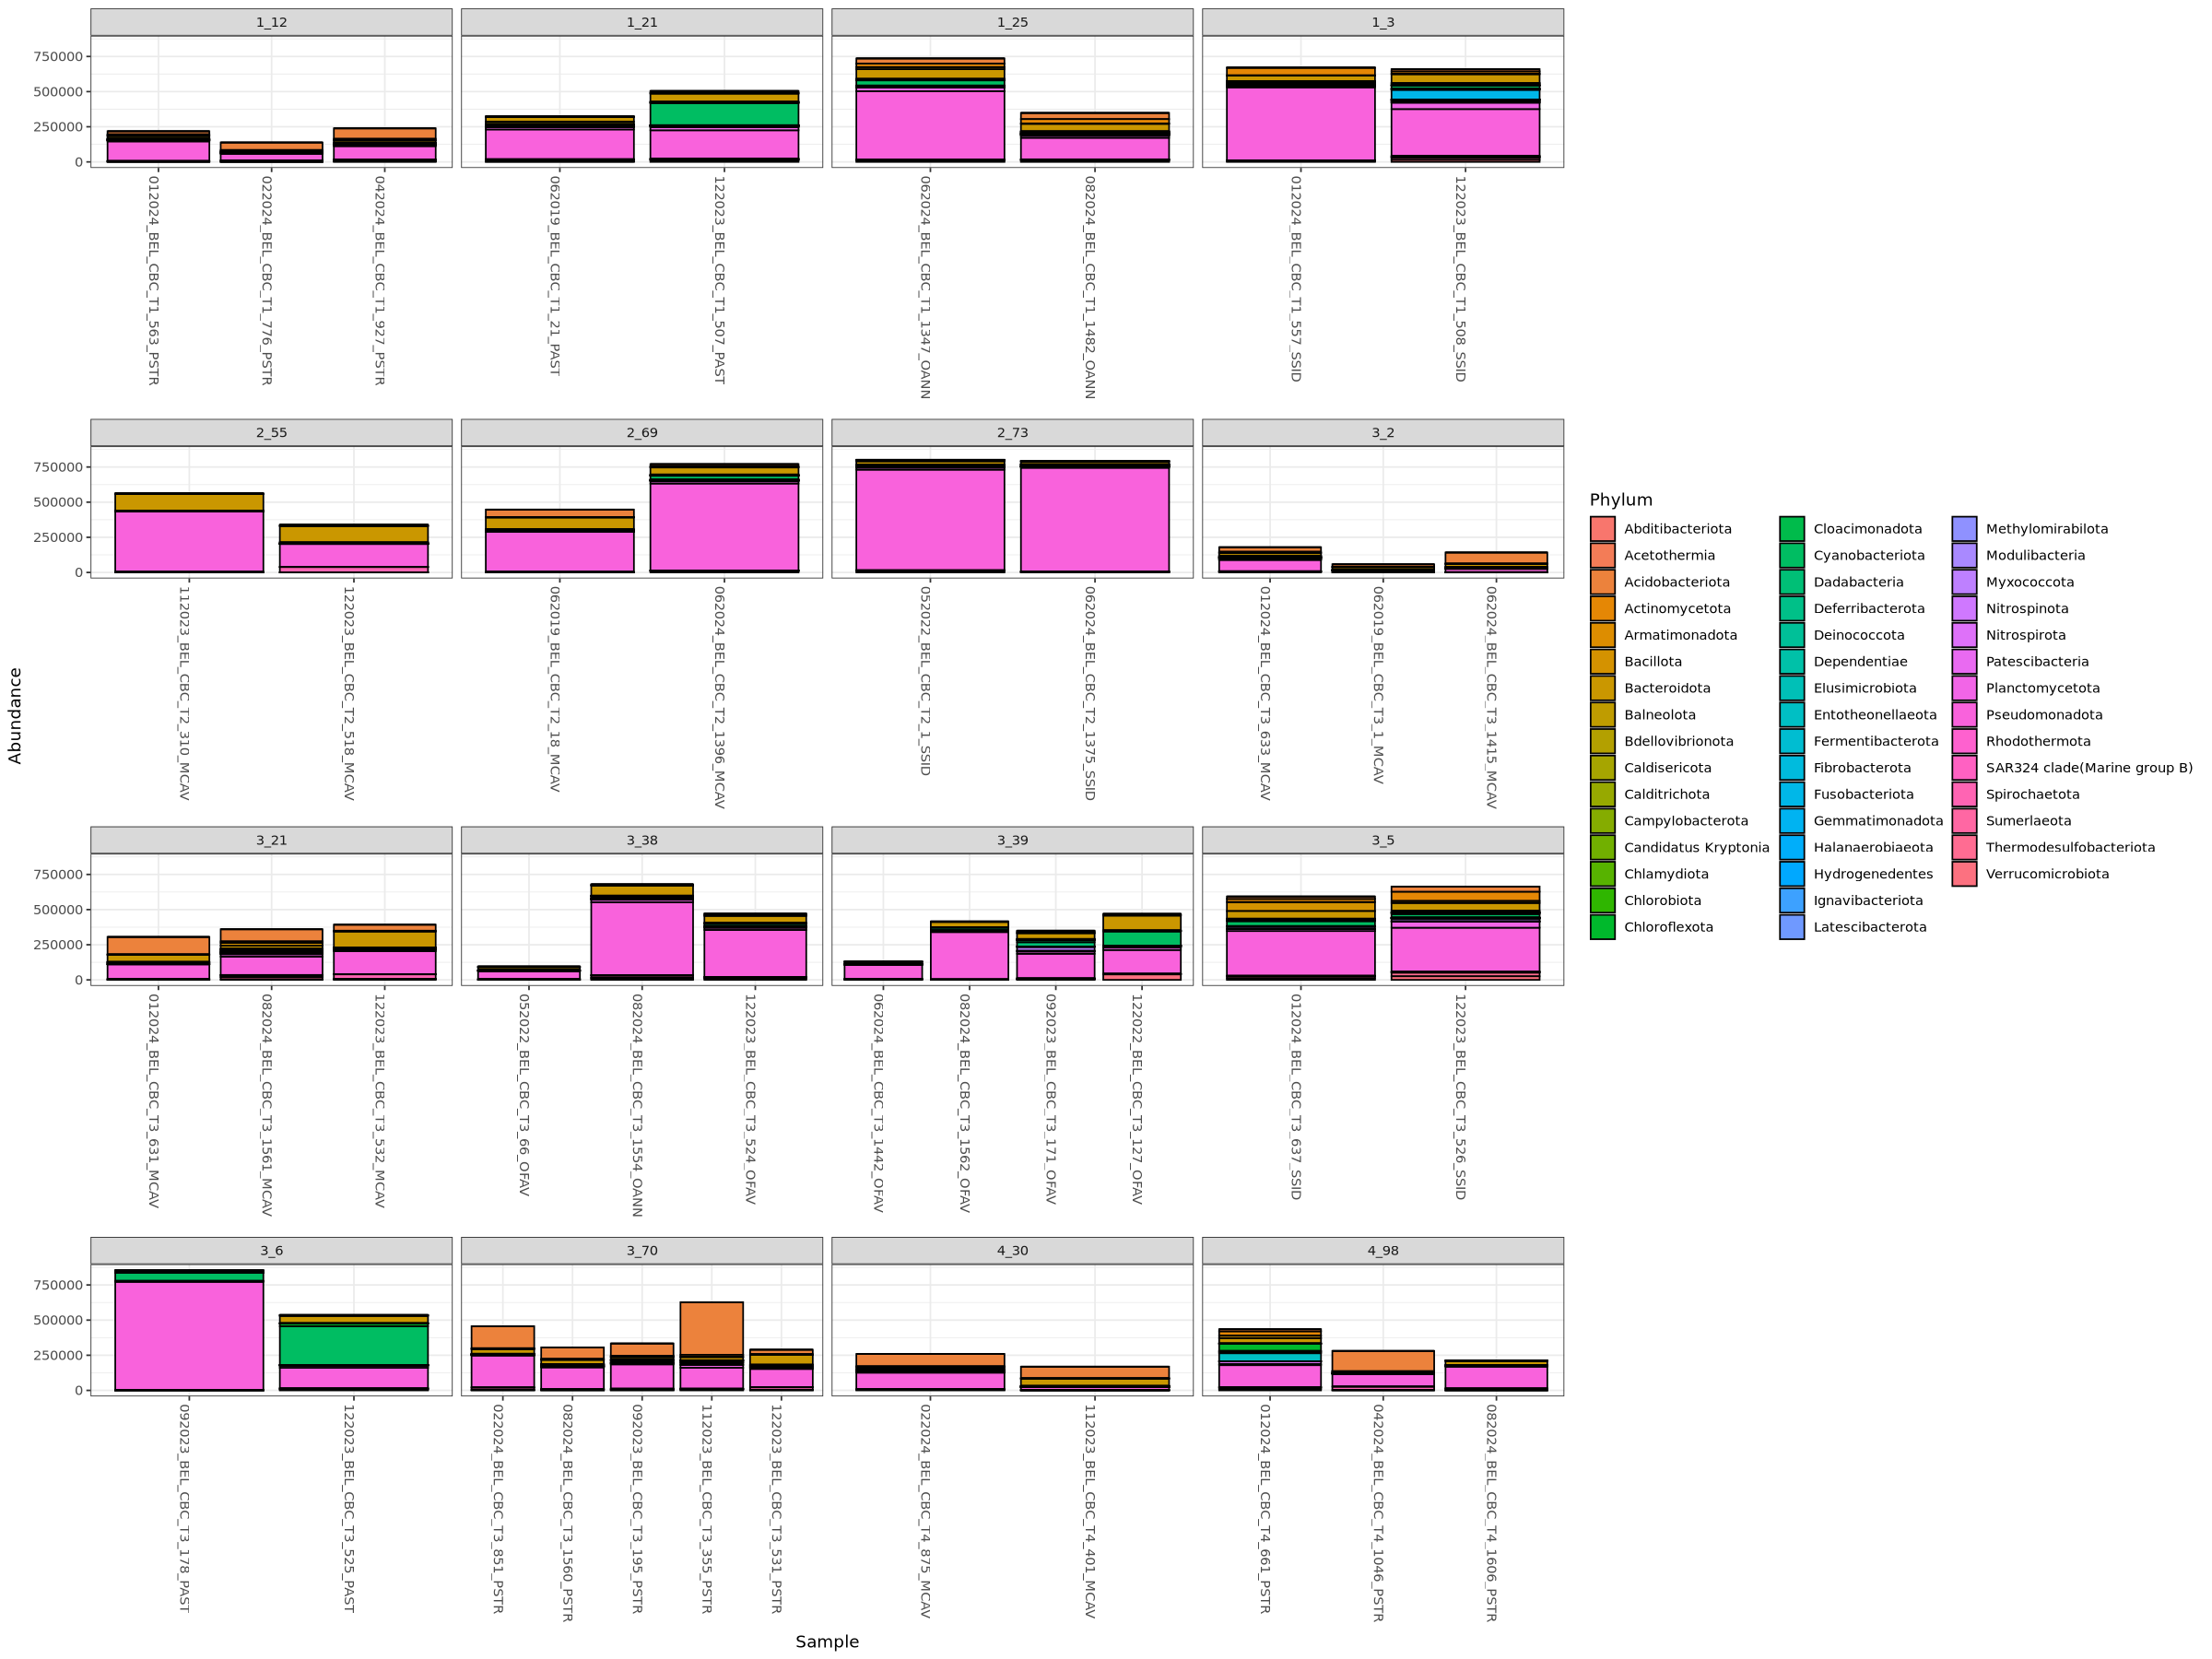

In [61]:
#one style of plot
ps_clean_glom=tax_glom(ps_clean, taxrank="Phylum")
top100_col_glom <- names(sort(taxa_sums(ps_clean_glom), decreasing=TRUE))[1:100]  
ps_clean_glom_top100 <- prune_taxa(top100_col_glom, ps_clean_glom) 
plot_bar(ps_clean_glom_top100, fill="Phylum")+ facet_wrap(~colony, scales="free_x")

### all species

In [26]:
class(ps_clean)

[1] "phyloseq"
attr(,"package")
[1] "phyloseq"

In [32]:
    # Get unique categories
    unique_taxa <- unique(tax_table(ps_clean)[, "Family"])
length(unique_taxa)

[1] 50

In [33]:
ps_clean=tax_glom(ps_clean, taxrank= "Family")

top50 <- names(sort(taxa_sums(ps_clean), decreasing=TRUE))[1:50] 
ps_clean <- prune_taxa(top50, ps_clean) 

In [34]:
length(unique_taxa)

[1] 50

In [35]:
#making this plot wider
options(repr.plot.width=30, repr.plot.height=15)

mycolors= colorRampPalette(brewer.pal(8, "Accent"))(50)

In [36]:
# Generate a random set of colors
    mycolors <- sample(mycolors, 50, length(unique_taxa))

    # Create a named color palette
    mycolors<- setNames(mycolors, unique_taxa)

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the phyloseq package.
  Please report the issue at <https://github.com/joey711/phyloseq/issues>.”


<Guides[1] ggproto object>

colour : <GuideLegend>

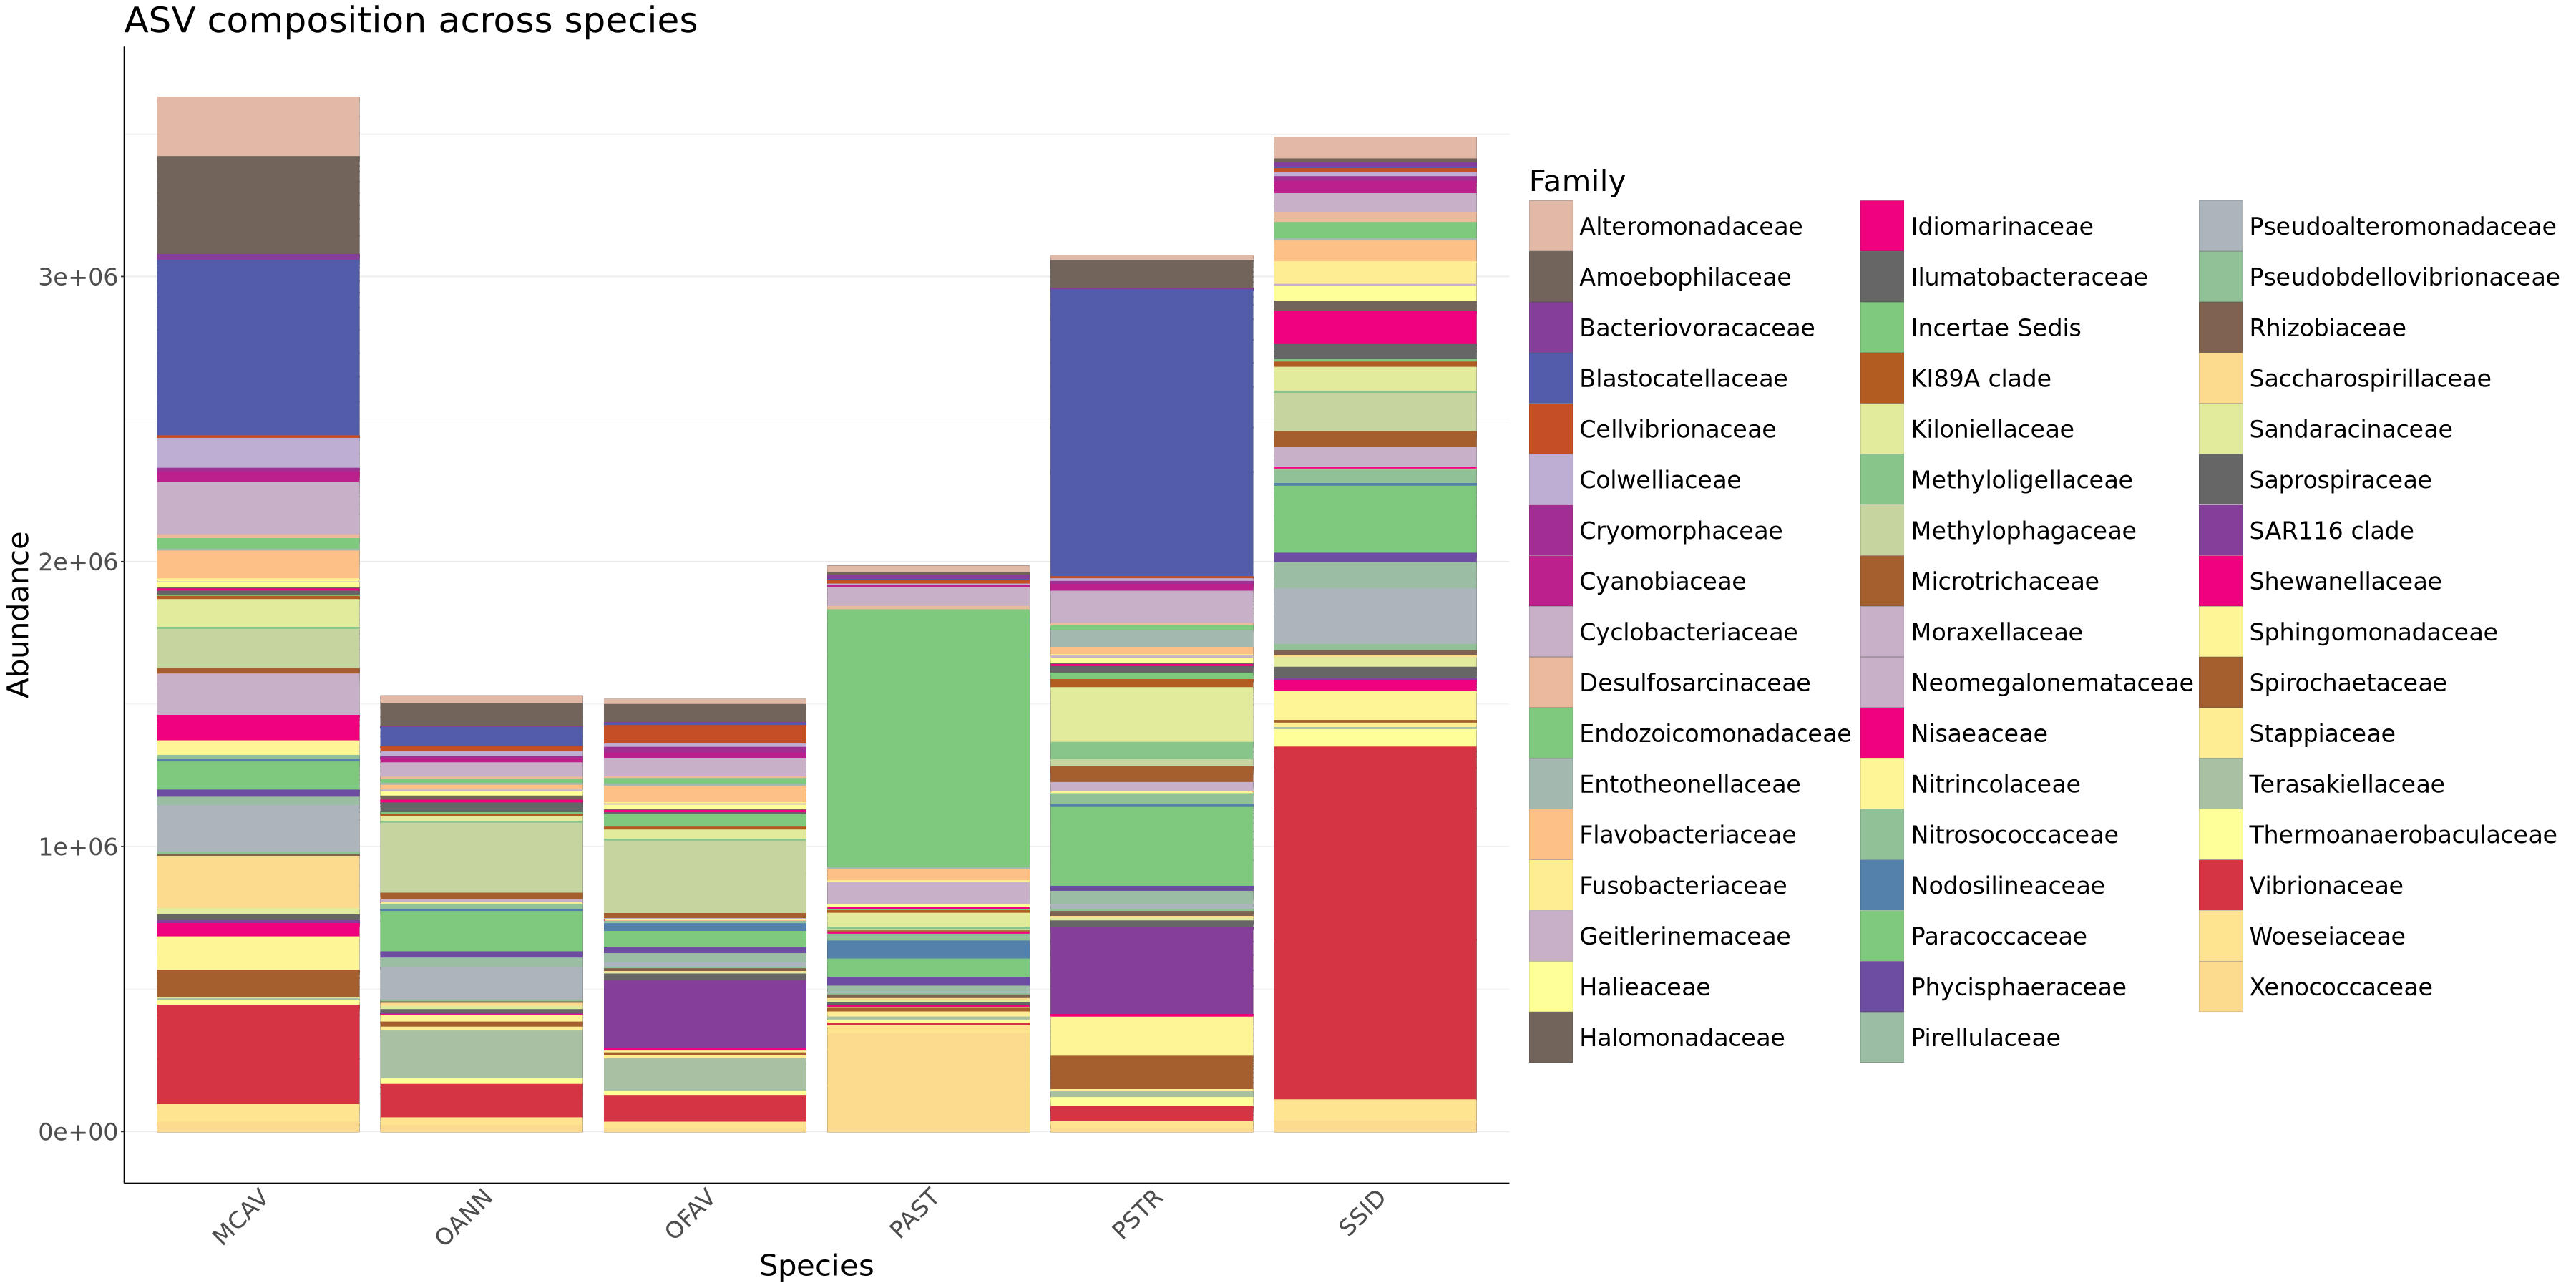

In [37]:
#plot
all <- plot_bar(ps_clean, x="species", fill = "Family") +
  geom_bar(aes(color = Family, fill = Family), 
           stat = "identity", position = "stack") +
  labs(title = "ASV composition across species",
       x = "Species",
       y = "Abundance",
       color = "Family") +
  scale_fill_manual(values = mycolors, drop = TRUE) +
  scale_color_manual(values = mycolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
    legend.title = element_text(size = 25),
  legend.text = element_text(size = 20),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 25)
  )
guides(color = guide_legend(override.aes = list(size = 6))) 
all

In [60]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/all_family.png", plot = all, width = 32, height = 15, units = "in", dpi = 300)

In [38]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/species_family.png", plot = all, width = 32, height = 15, units = "in", dpi = 300)

#### subset sample by species

In [39]:
#new dataframes for each species 
ps_mcav <- subset_samples(ps_clean, species == "MCAV")
ps_pstr <- subset_samples(ps_clean, species == "PSTR")
ps_ofav <- subset_samples(ps_clean, species == "OFAV")
ps_ssid <- subset_samples(ps_clean, species == "SSID")
ps_oann <- subset_samples(ps_clean, species == "OANN")
ps_past <- subset_samples(ps_clean, species == "PAST") 

In [40]:
#should add up to 42 samples
nrow(sample_data(ps_mcav))
nrow(sample_data(ps_pstr))
nrow(sample_data(ps_ofav))
nrow(sample_data(ps_oann))
nrow(sample_data(ps_ssid))
nrow(sample_data(ps_past))

[1] 12

[1] 11

[1] 6

[1] 3

[1] 6

[1] 4

In [41]:
table(sample_data(ps_clean)[,"colony"])

colony
1_12 1_21 1_25  1_3 2_55 2_69 2_73  3_2 3_21 3_38 3_39  3_5  3_6 3_70 4_30 4_98 
   3    2    2    2    2    2    2    3    3    3    4    2    2    5    2    3 

### family plots

In [42]:
#confrim chronological order worked
levels(sample_data(ps_past)$MonthYear)

[1] "Jun 2019" "Sep 2023" "Dec 2023"

Warning message in geom_text(aes(label = Family, fill = Family), position = position_stack(vjust = 0.5), :
“Ignoring unknown aesthetics: fill”


<Guides[1] ggproto object>

colour : <GuideLegend>

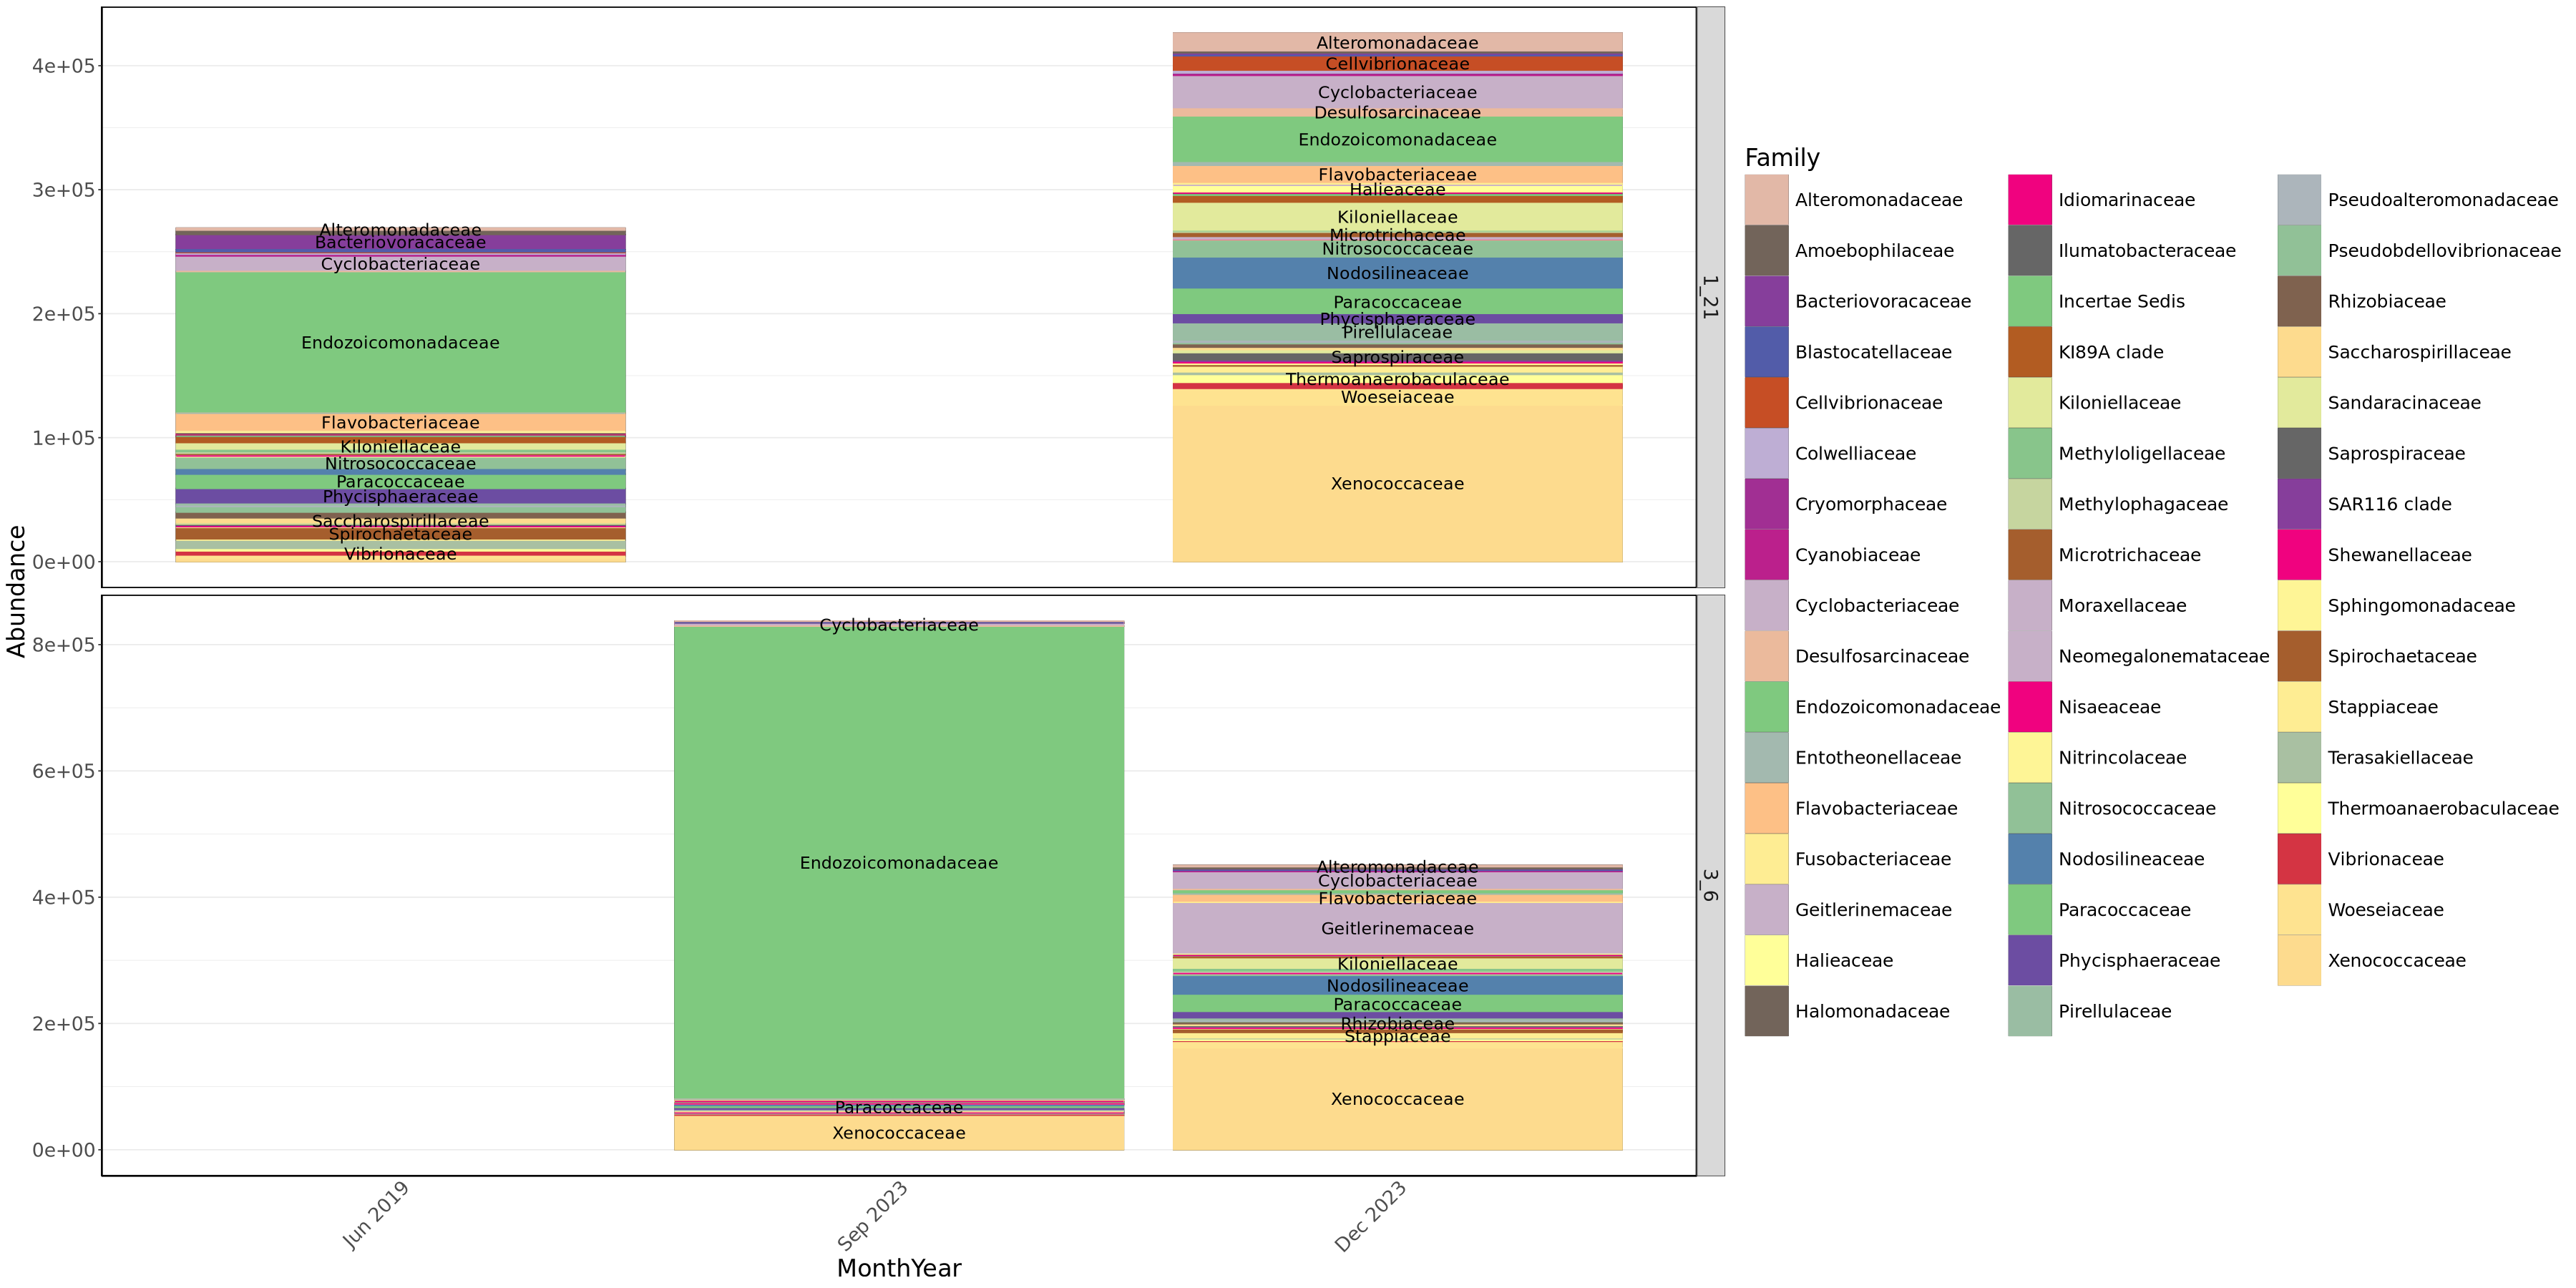

In [43]:
ps_past=tax_glom(ps_past, taxrank= "Family")

top50_past <- names(sort(taxa_sums(ps_past), decreasing=TRUE))[1:50] 
top50_past <- prune_taxa(top50_past, ps_past) 

#plot
past <- plot_bar(top50_past, x="MonthYear", fill = "Family") +
  facet_wrap(colony ~., strip.position = "right", ncol = 1, scales = "free_y") +
  geom_bar(aes(color = Family, fill = Family), 
           stat = "identity", position = "stack") +
  geom_text(aes(label = Family, fill = Family),
            position = position_stack(vjust = 0.5),
            color = "black", size = 5, check_overlap = TRUE) +
  scale_fill_manual(values = mycolors, drop = TRUE) +
  scale_color_manual(values = mycolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
      legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 20)
  )
guides(color = guide_legend(override.aes = list(size = 6))) 
past

In [44]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/past_family.png", plot = past, width = 32, height = 15, units = "in", dpi = 300)

Warning message in geom_text(aes(label = Family, fill = Family), position = position_stack(vjust = 0.5), :
“Ignoring unknown aesthetics: fill”


<Guides[1] ggproto object>

colour : <GuideLegend>

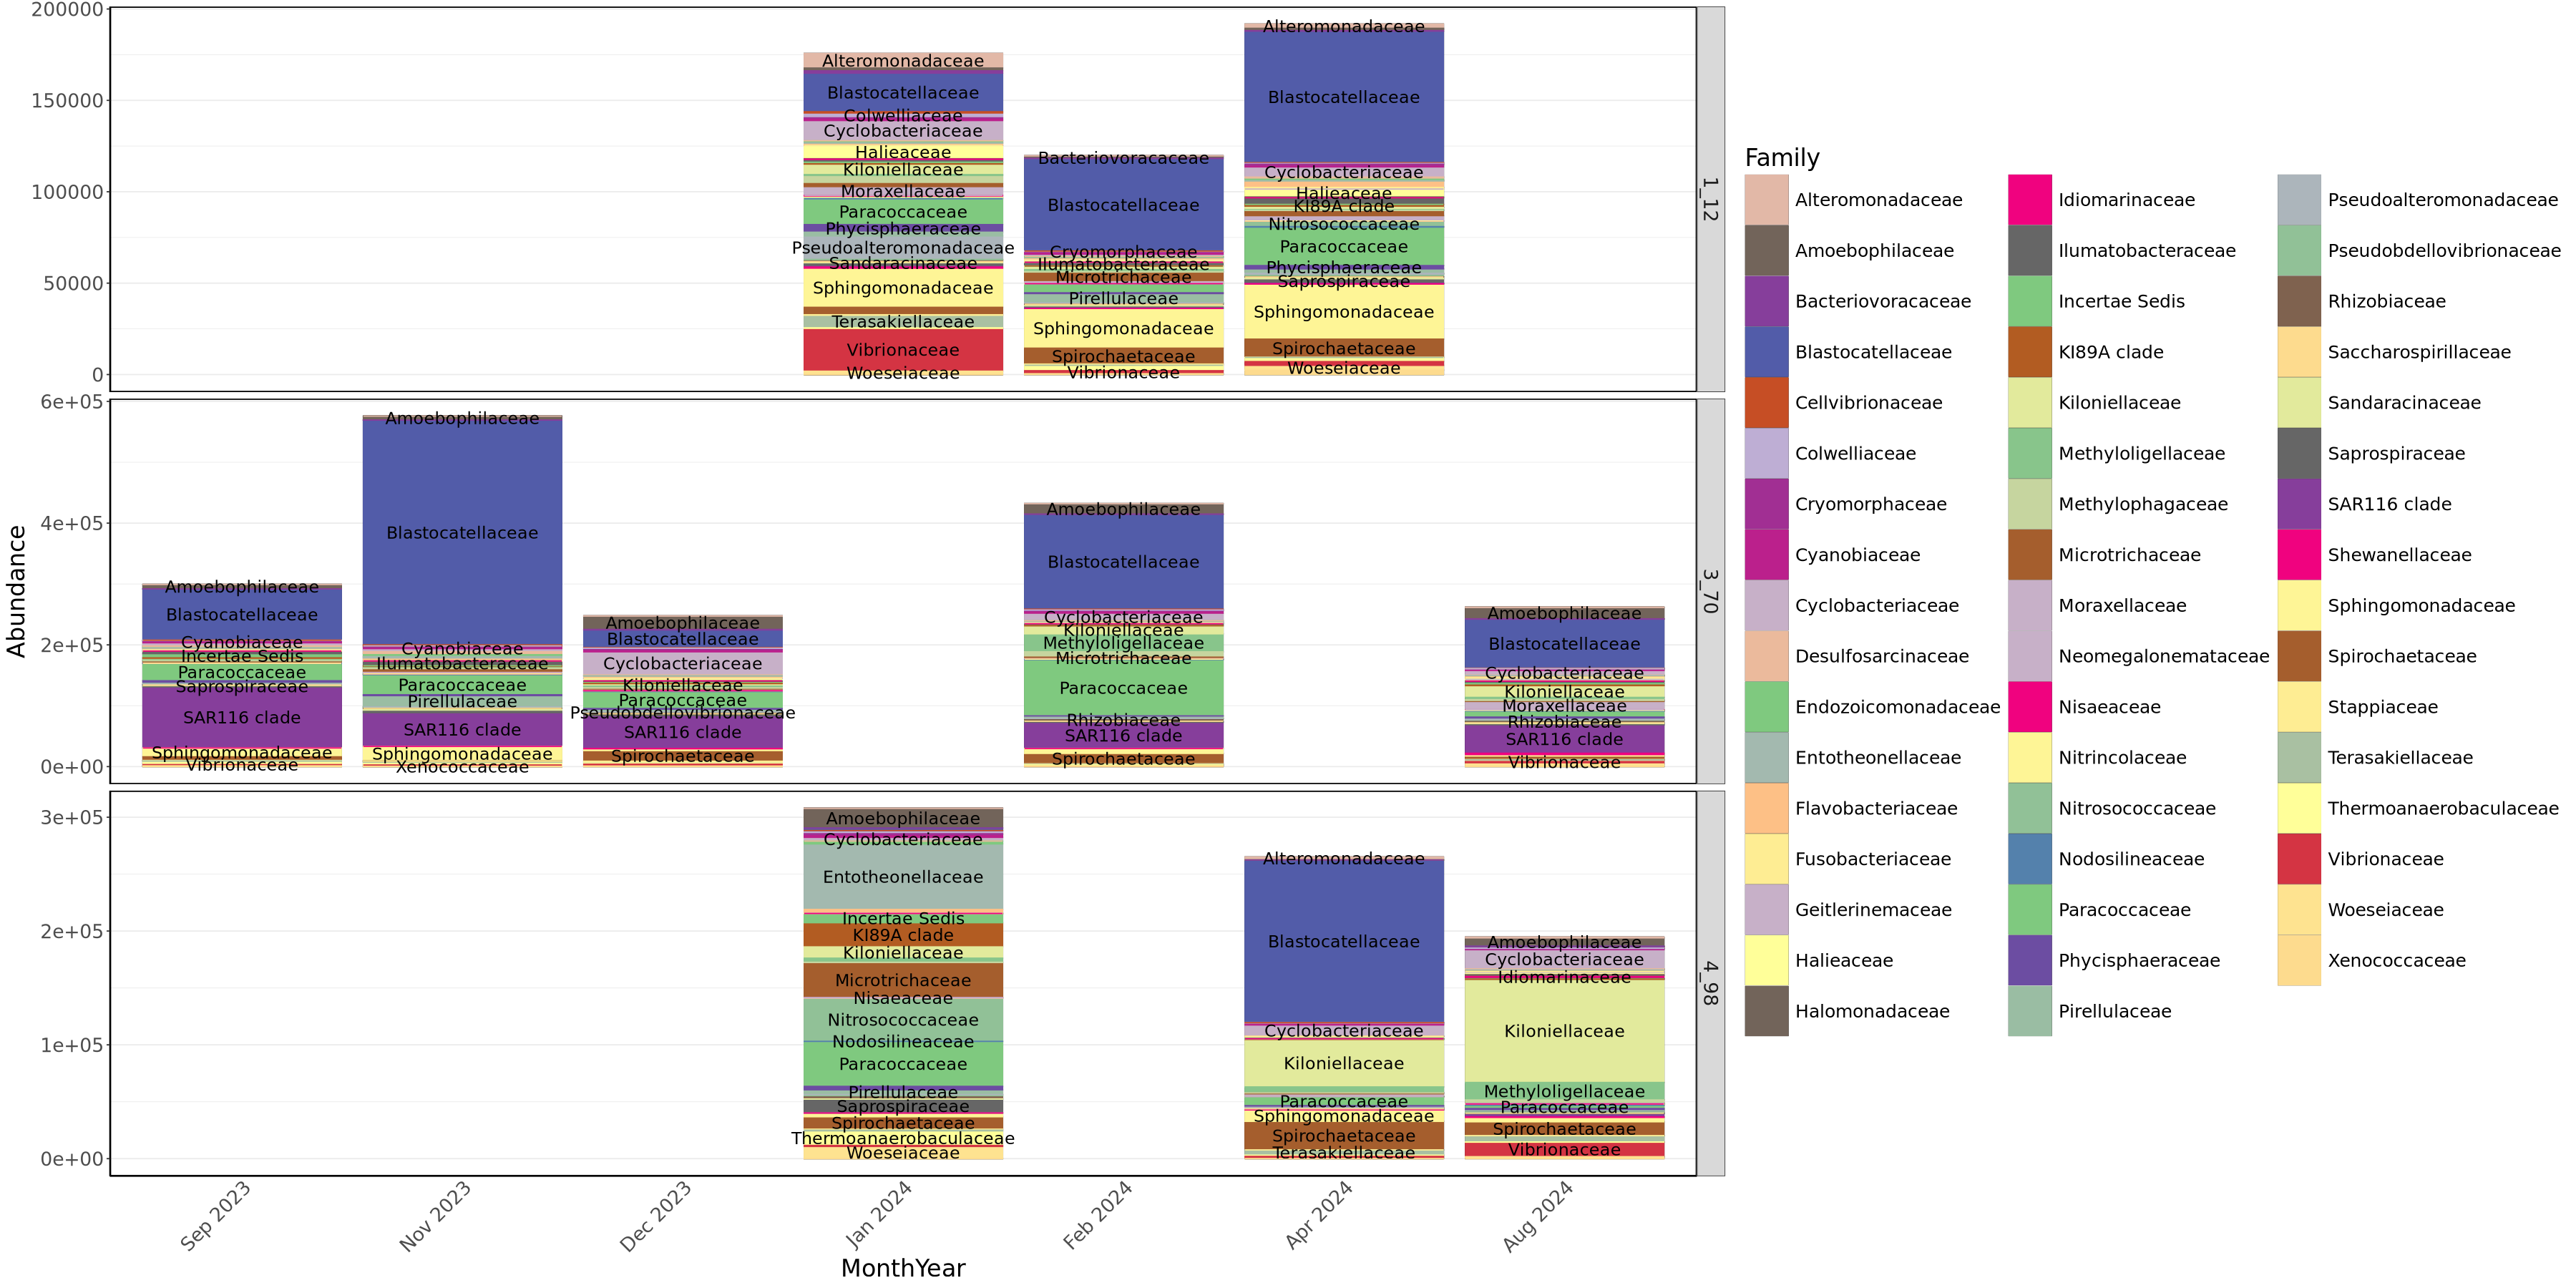

In [45]:
#plot
pstr <- plot_bar(ps_pstr, x="MonthYear", fill="Family") +
   facet_wrap(colony ~., strip.position = "right", ncol = 1, scales = "free_y") +
  geom_bar(aes(color = Family, fill = Family), 
           stat = "identity", position = "stack") +
  geom_text(aes(label = Family, fill = Family),
            position = position_stack(vjust = 0.5),
            color = "black", size = 5, check_overlap = TRUE) +
  scale_fill_manual(values = mycolors, drop = TRUE) +
  scale_color_manual(values = mycolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
      legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 20)
  )
guides(color = guide_legend(override.aes = list(size = 6))) 
pstr

In [46]:
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/pstr_family.png", plot = pstr, width = 32, height = 15, units = "in", dpi = 300)

### order plots

In [31]:
#color assignment
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(50)

#sizing plots
options(repr.plot.width=30, repr.plot.height=15)

Warning message in geom_text(aes(label = Order, fill = Order), position = position_stack(vjust = 0.5), :
“Ignoring unknown aesthetics: fill”


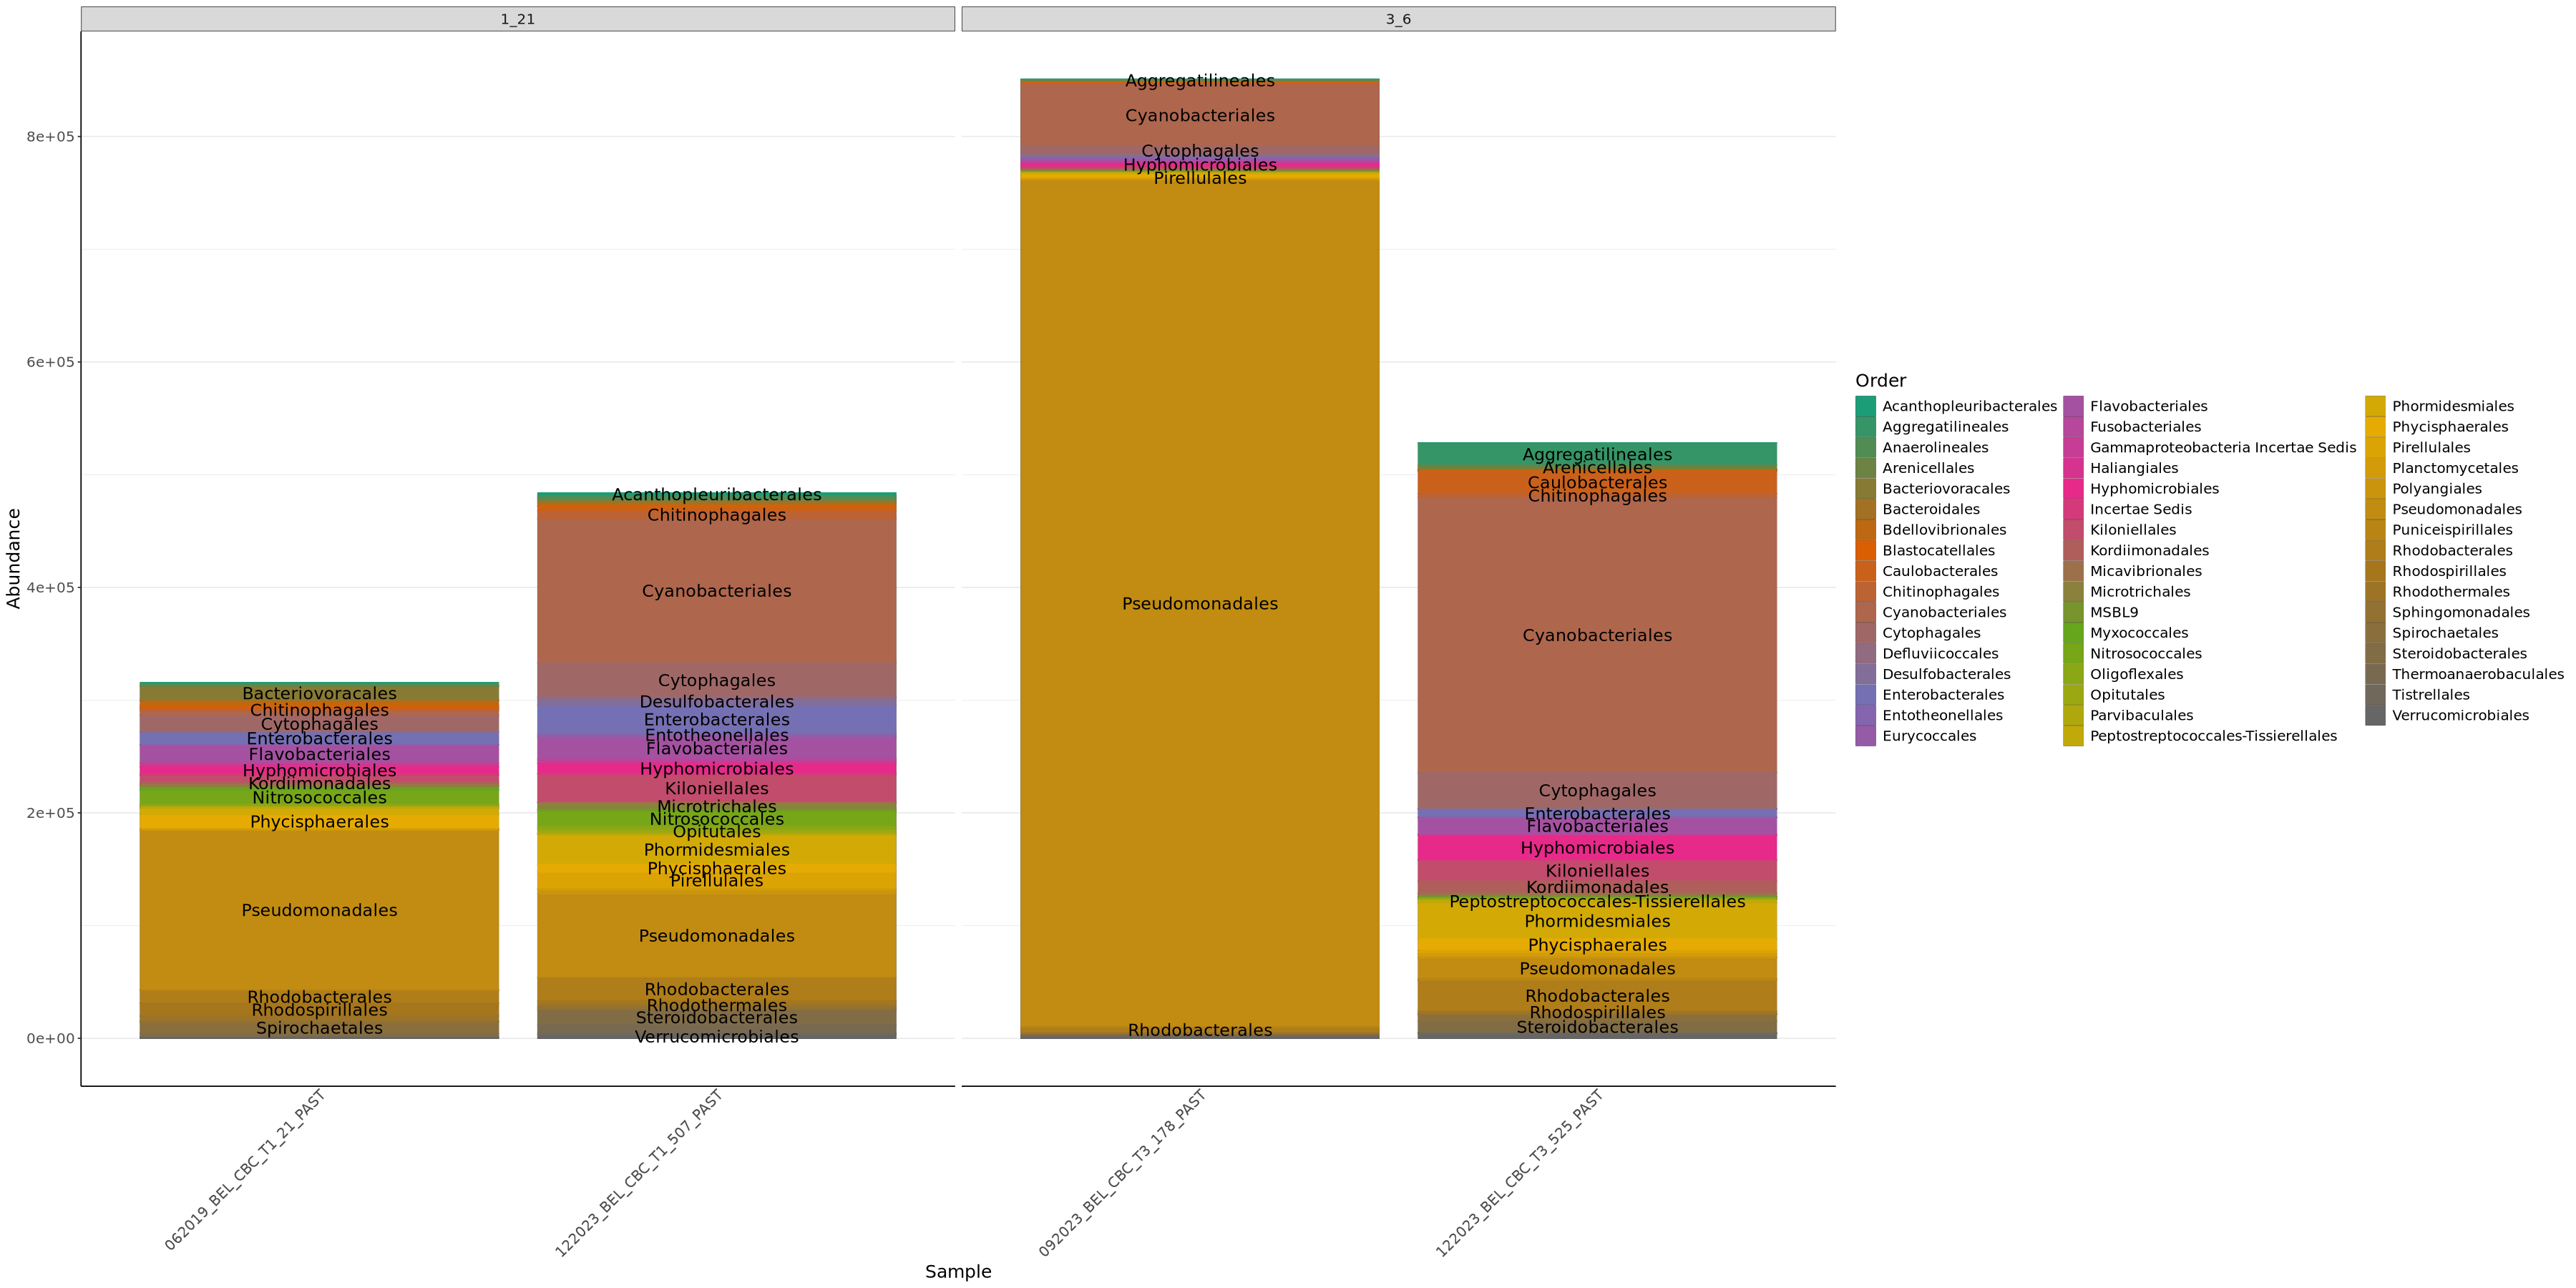

In [32]:
ord_past=tax_glom(ord_past, taxrank="Order")

top50_past <- names(sort(taxa_sums(ord_past), decreasing=TRUE))[1:50] 
top50_past <- prune_taxa(top50_past, ord_past) 

#plot
past <- plot_bar(top50_past, fill = "Order") +
  facet_grid(. ~ colony, scales = "free_x") +
  geom_bar(aes(color = Order, fill = Order), 
           stat = "identity", position = "stack") +
  geom_text(aes(label = Order, fill = Order),
            position = position_stack(vjust = 0.5),
            color = "black", size = 5, check_overlap = TRUE) +
  scale_fill_manual(values = mycolors, drop = TRUE) +
  scale_color_manual(values = mycolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 15)
  )
past

In [ ]:
ord_pstr=tax_glom(ord_pstr, taxrank="Order")

top50_pstr <- names(sort(taxa_sums(ord_pstr), decreasing=TRUE))[1:50] 
top50_pstr <- prune_taxa(top50_pstr, ord_pstr) 

#plot
plot_pstr <- plot_bar(top50_pstr,  fill="Order") +
  facet_grid(. ~ colony, scales = "free_x") +
  geom_bar(aes(color = Order, fill = Order), 
           stat = "identity", position = "stack") +
  geom_text(aes(label = Order, fill = Order),
            position = position_stack(vjust = 0.5),
            color = "black", size = 5, check_overlap = TRUE) +
  scale_fill_manual(values = mycolors, drop = TRUE) +
  scale_color_manual(values = mycolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 18)
  )
plot_pstr

### class plots for each species

In [25]:
#color assignment
mycolors= colorRampPalette(brewer.pal(12, "Set3"))(100)

#sizing plots
options(repr.plot.width=30, repr.plot.height=15)

Warning message in geom_text(aes(label = Class, fill = Class), position = position_stack(vjust = 0.5), :
“Ignoring unknown aesthetics: fill”


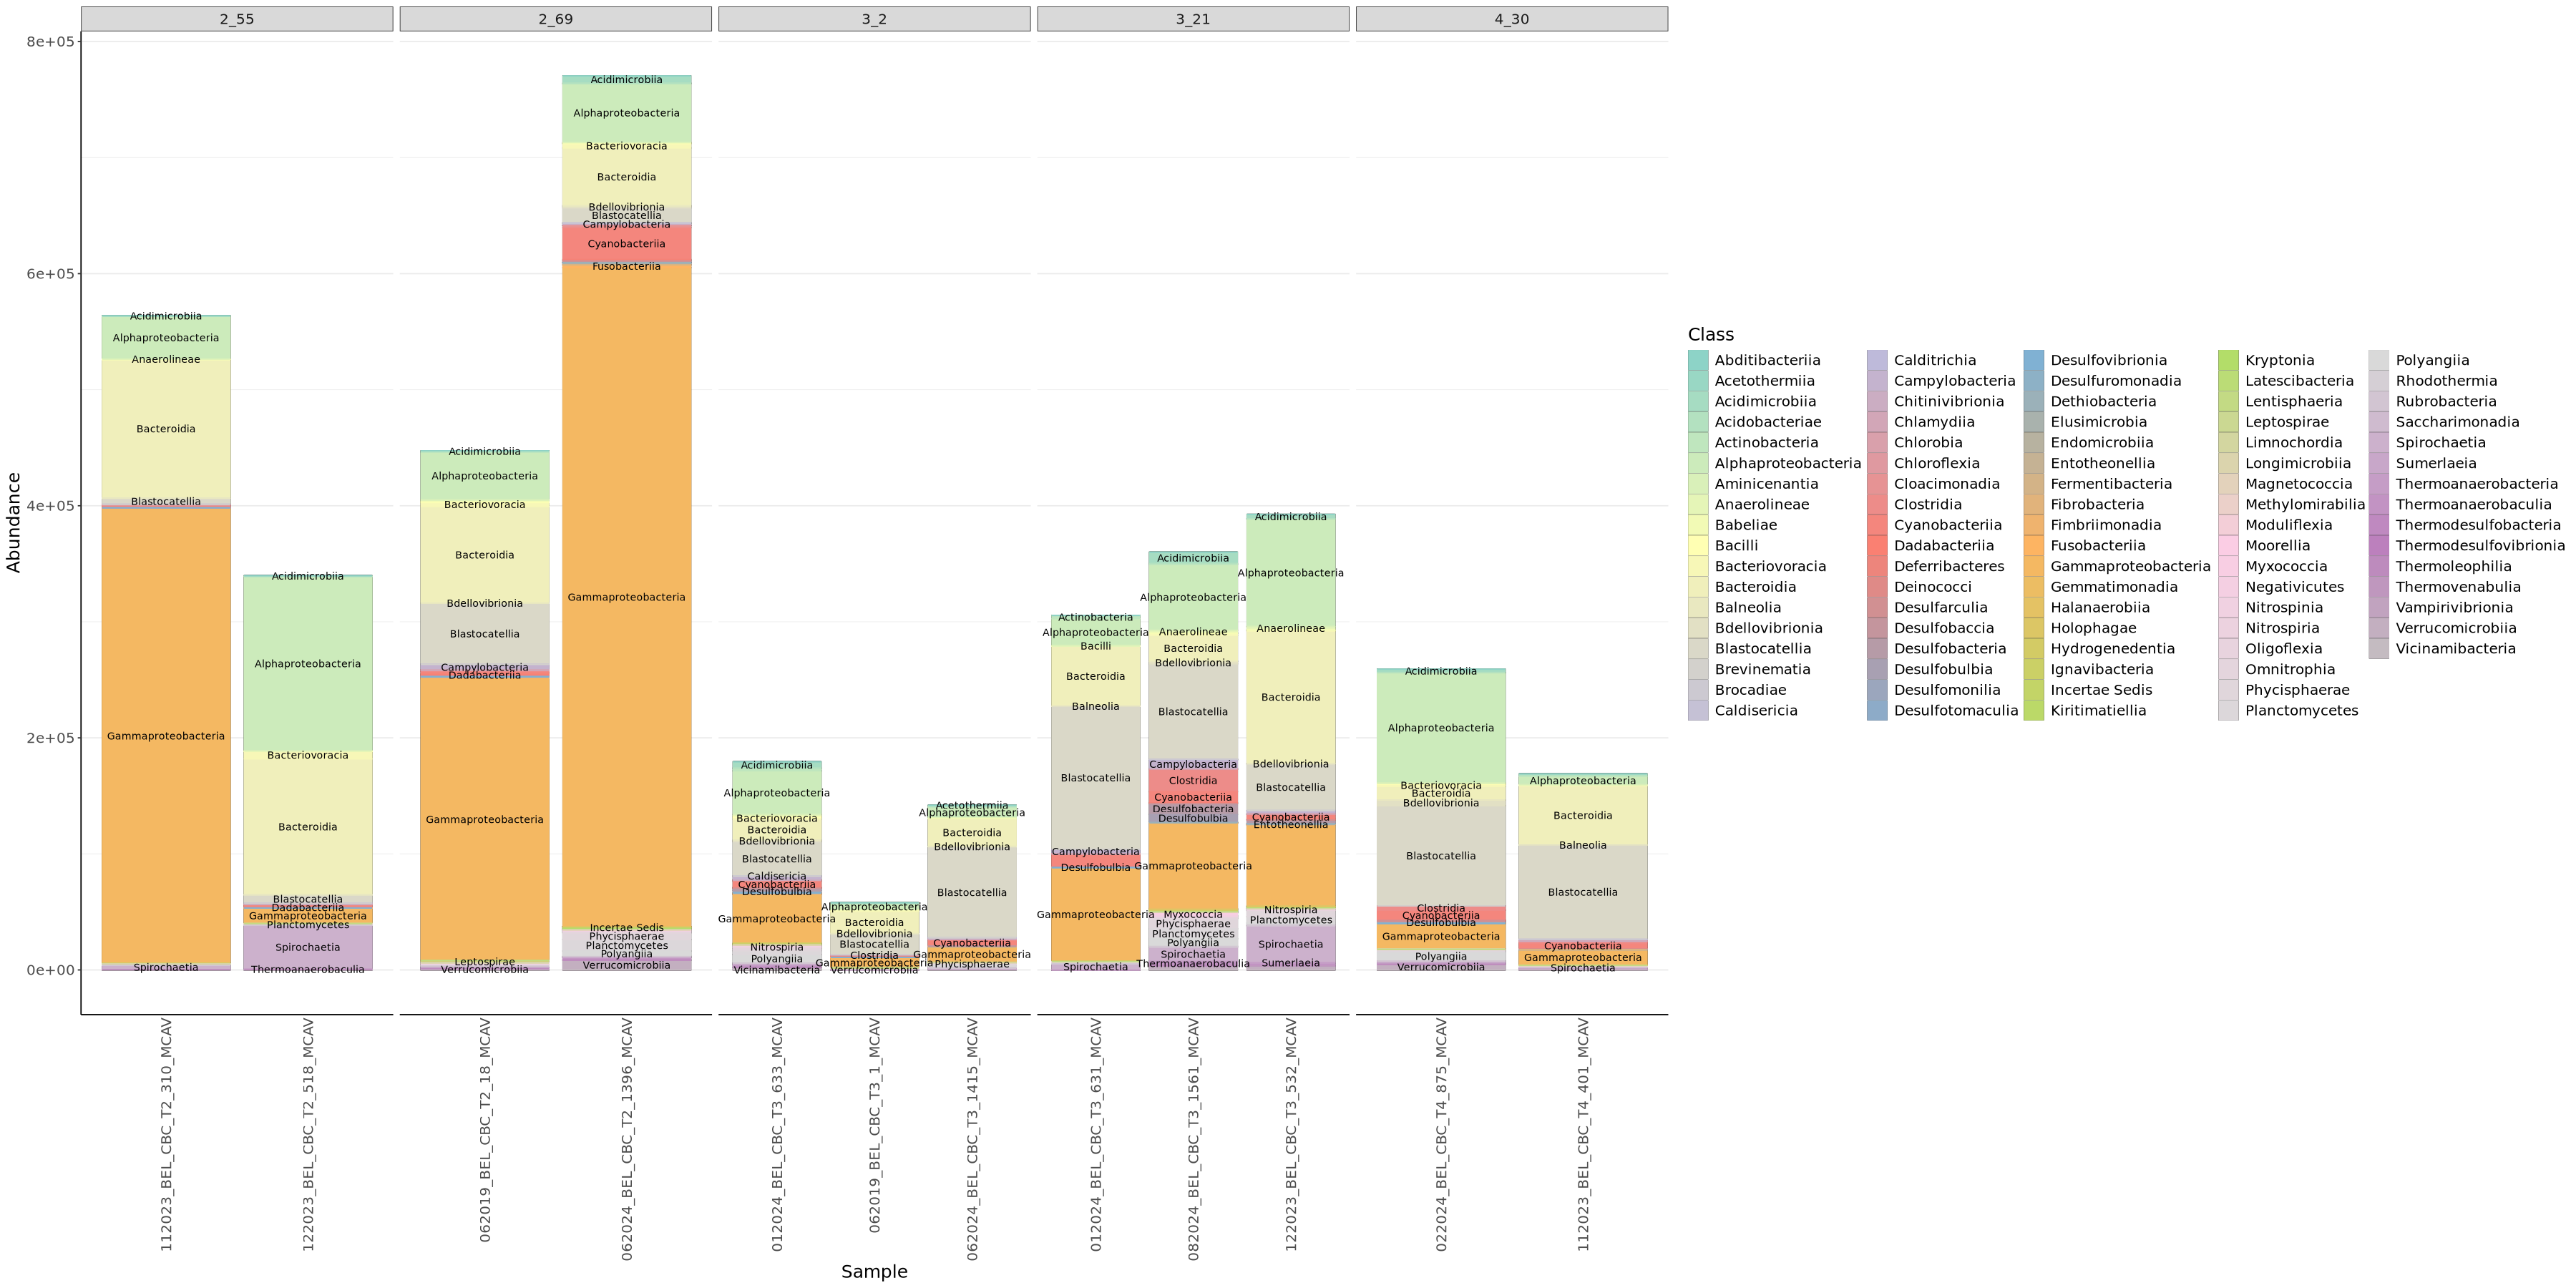

In [70]:
ps_mcav=tax_glom(ps_mcav, taxrank="Class")

top100_mcav <- names(sort(taxa_sums(ps_mcav), decreasing=TRUE))[1:100] 
top100_mcav <- prune_taxa(top100_mcav, ps_mcav) 

#plot
plot_bar(top100_mcav,  fill="Class") +
  facet_grid(. ~ colony, scales = "free_x") +
  geom_bar(aes(color = Class, fill = Class), 
           stat = "identity", position = "stack") +
  geom_text(aes(label = Class, fill = Class),
            position = position_stack(vjust = 0.5),
            color = "black", size = 3, check_overlap = TRUE) +
  scale_fill_manual(values = mycolors, drop = TRUE) +
  scale_color_manual(values = mycolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    text = element_text(size = 15)
  )

Warning message in geom_text(aes(label = Class, fill = Class), position = position_stack(vjust = 0.5), :
“Ignoring unknown aesthetics: fill”


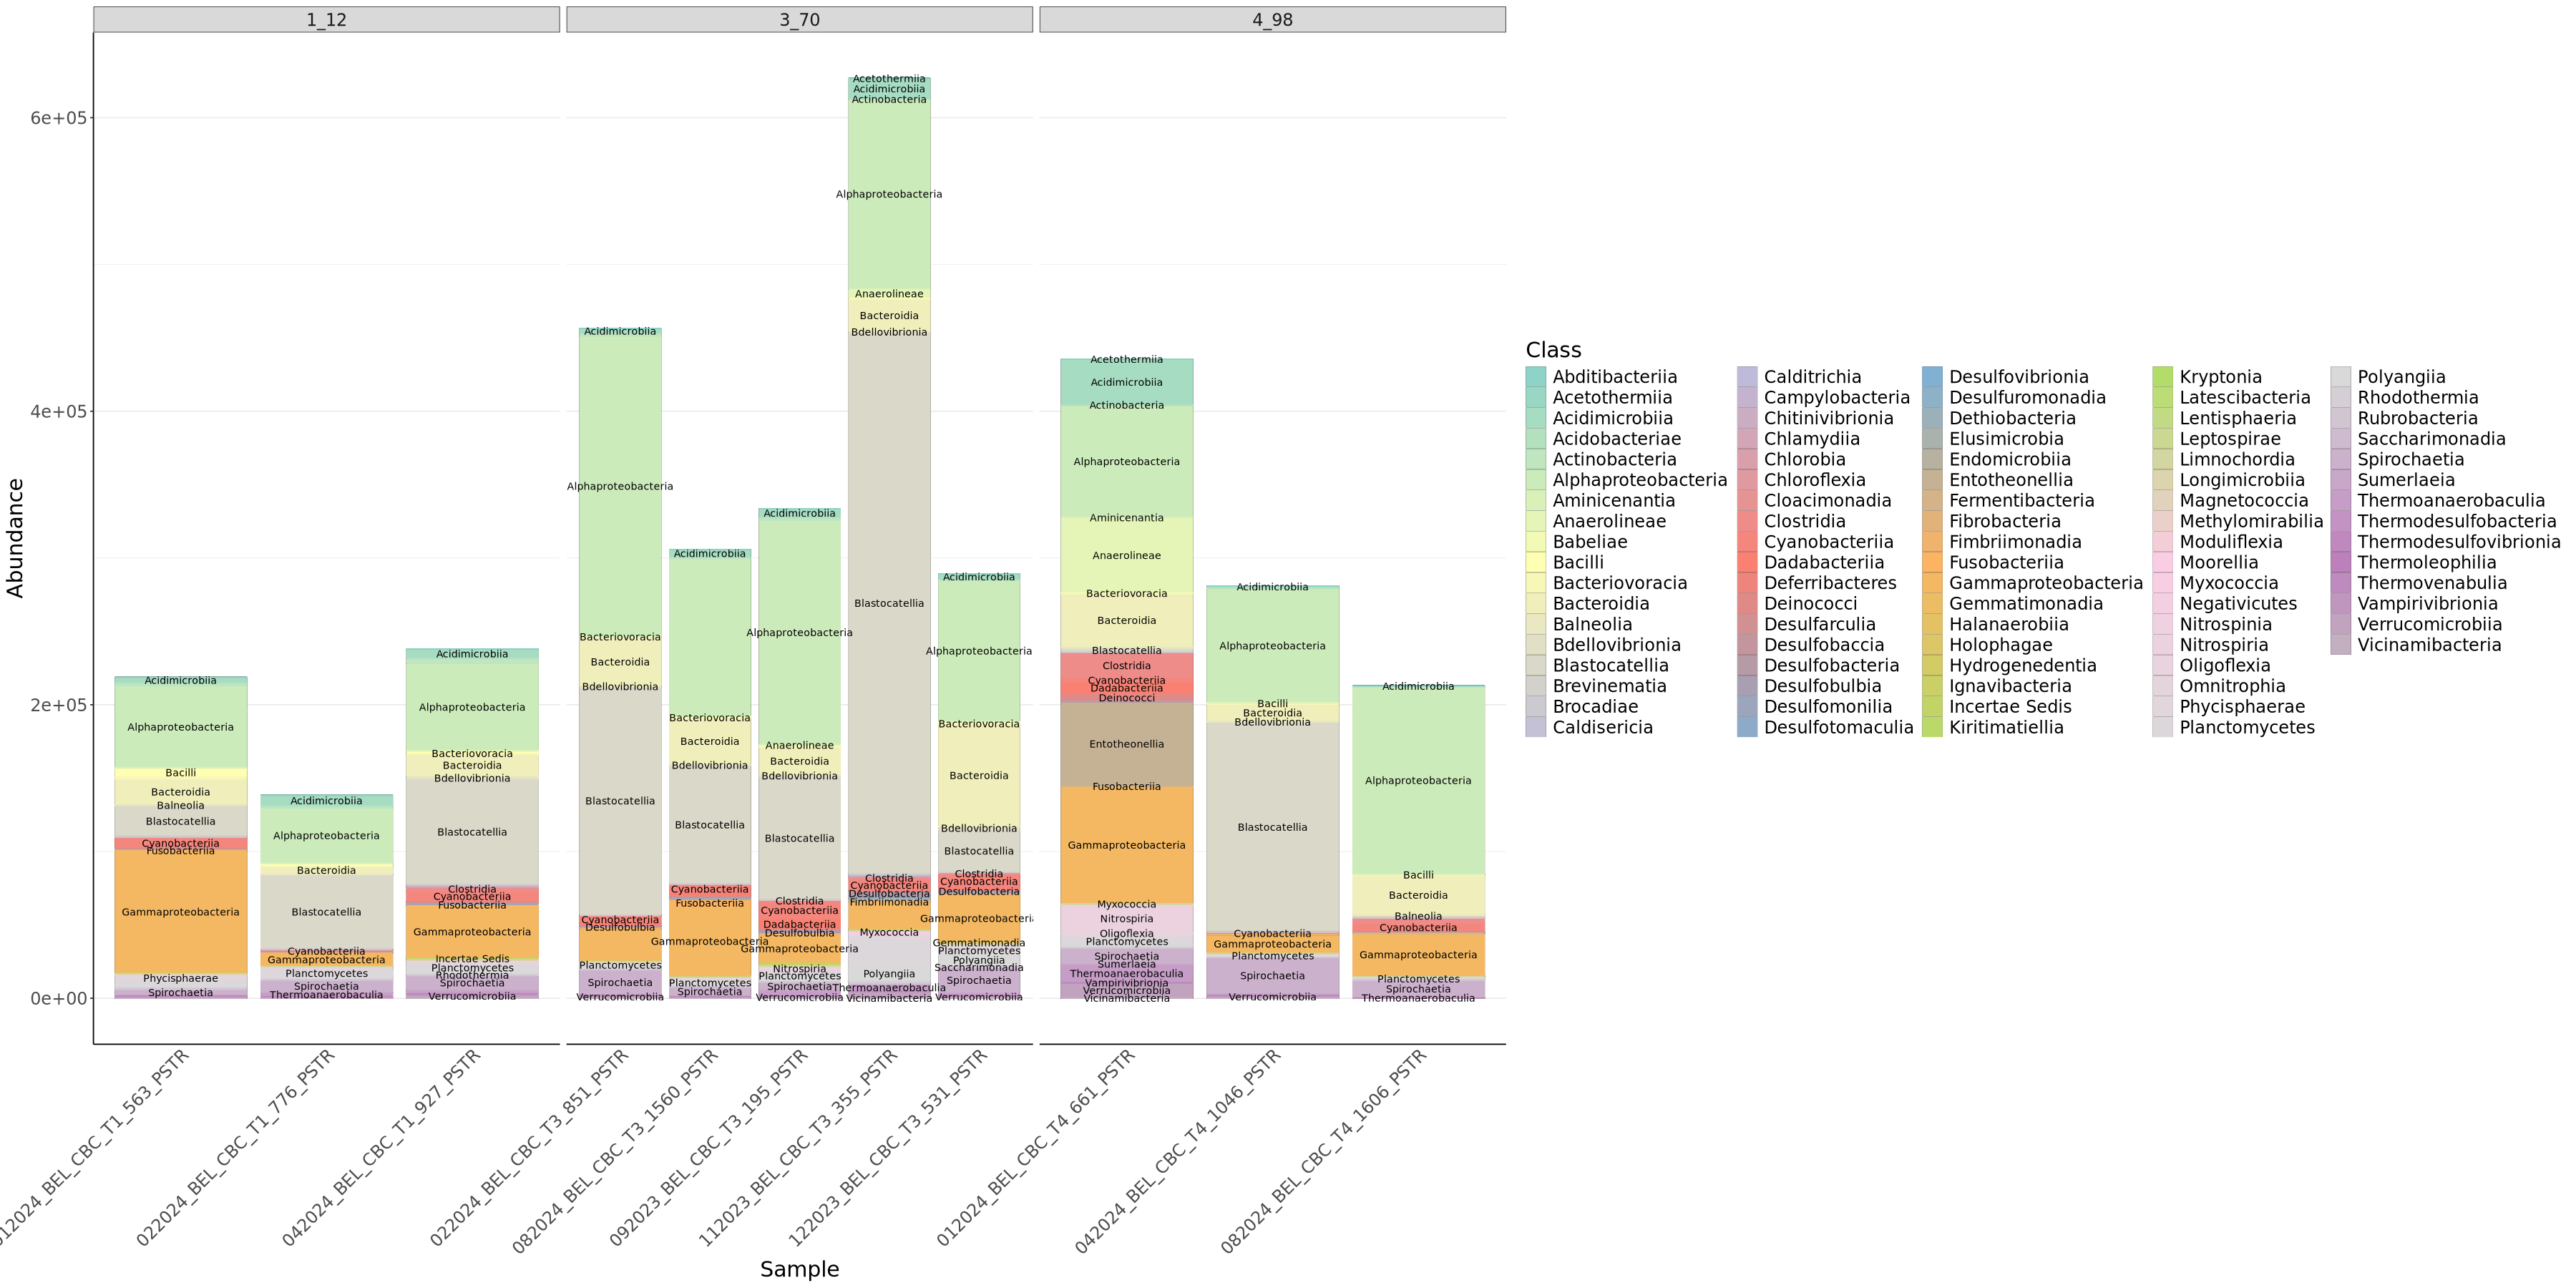

In [34]:
ps_pstr=tax_glom(ps_pstr, taxrank="Order")

top50_pstr <- names(sort(taxa_sums(ps_pstr), decreasing=TRUE))[1:50] 
top50_pstr <- prune_taxa(top50_pstr, ps_pstr) 

#plot
plot_pstr <- plot_bar(top50_pstr,  fill="Order") +
  facet_grid(. ~ colony, scales = "free_x") +
  geom_bar(aes(color = Order, fill = Order), 
           stat = "identity", position = "stack") +
  geom_text(aes(label = Order, fill = Order),
            position = position_stack(vjust = 0.5),
            color = "black", size = 3, check_overlap = TRUE) +
  scale_fill_manual(values = mycolors, drop = TRUE) +
  scale_color_manual(values = mycolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 18)
  )
plot_pstr

In [36]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plot_pstr_class.png", plot = plot_pstr, width = 32, height = 15, units = "in", dpi = 300)

In [38]:
#resizing plots for less samples
options(repr.plot.width=20, repr.plot.height=10)

In [39]:
ps_past=tax_glom(ps_past, taxrank="Class")

top100_past <- names(sort(taxa_sums(ps_past), decreasing=TRUE))[1:100] 
top100_past <- prune_taxa(top100_past, ps_past) 

Warning message in geom_text(aes(label = Class, fill = Class), position = position_stack(vjust = 0.5), :
“Ignoring unknown aesthetics: fill”


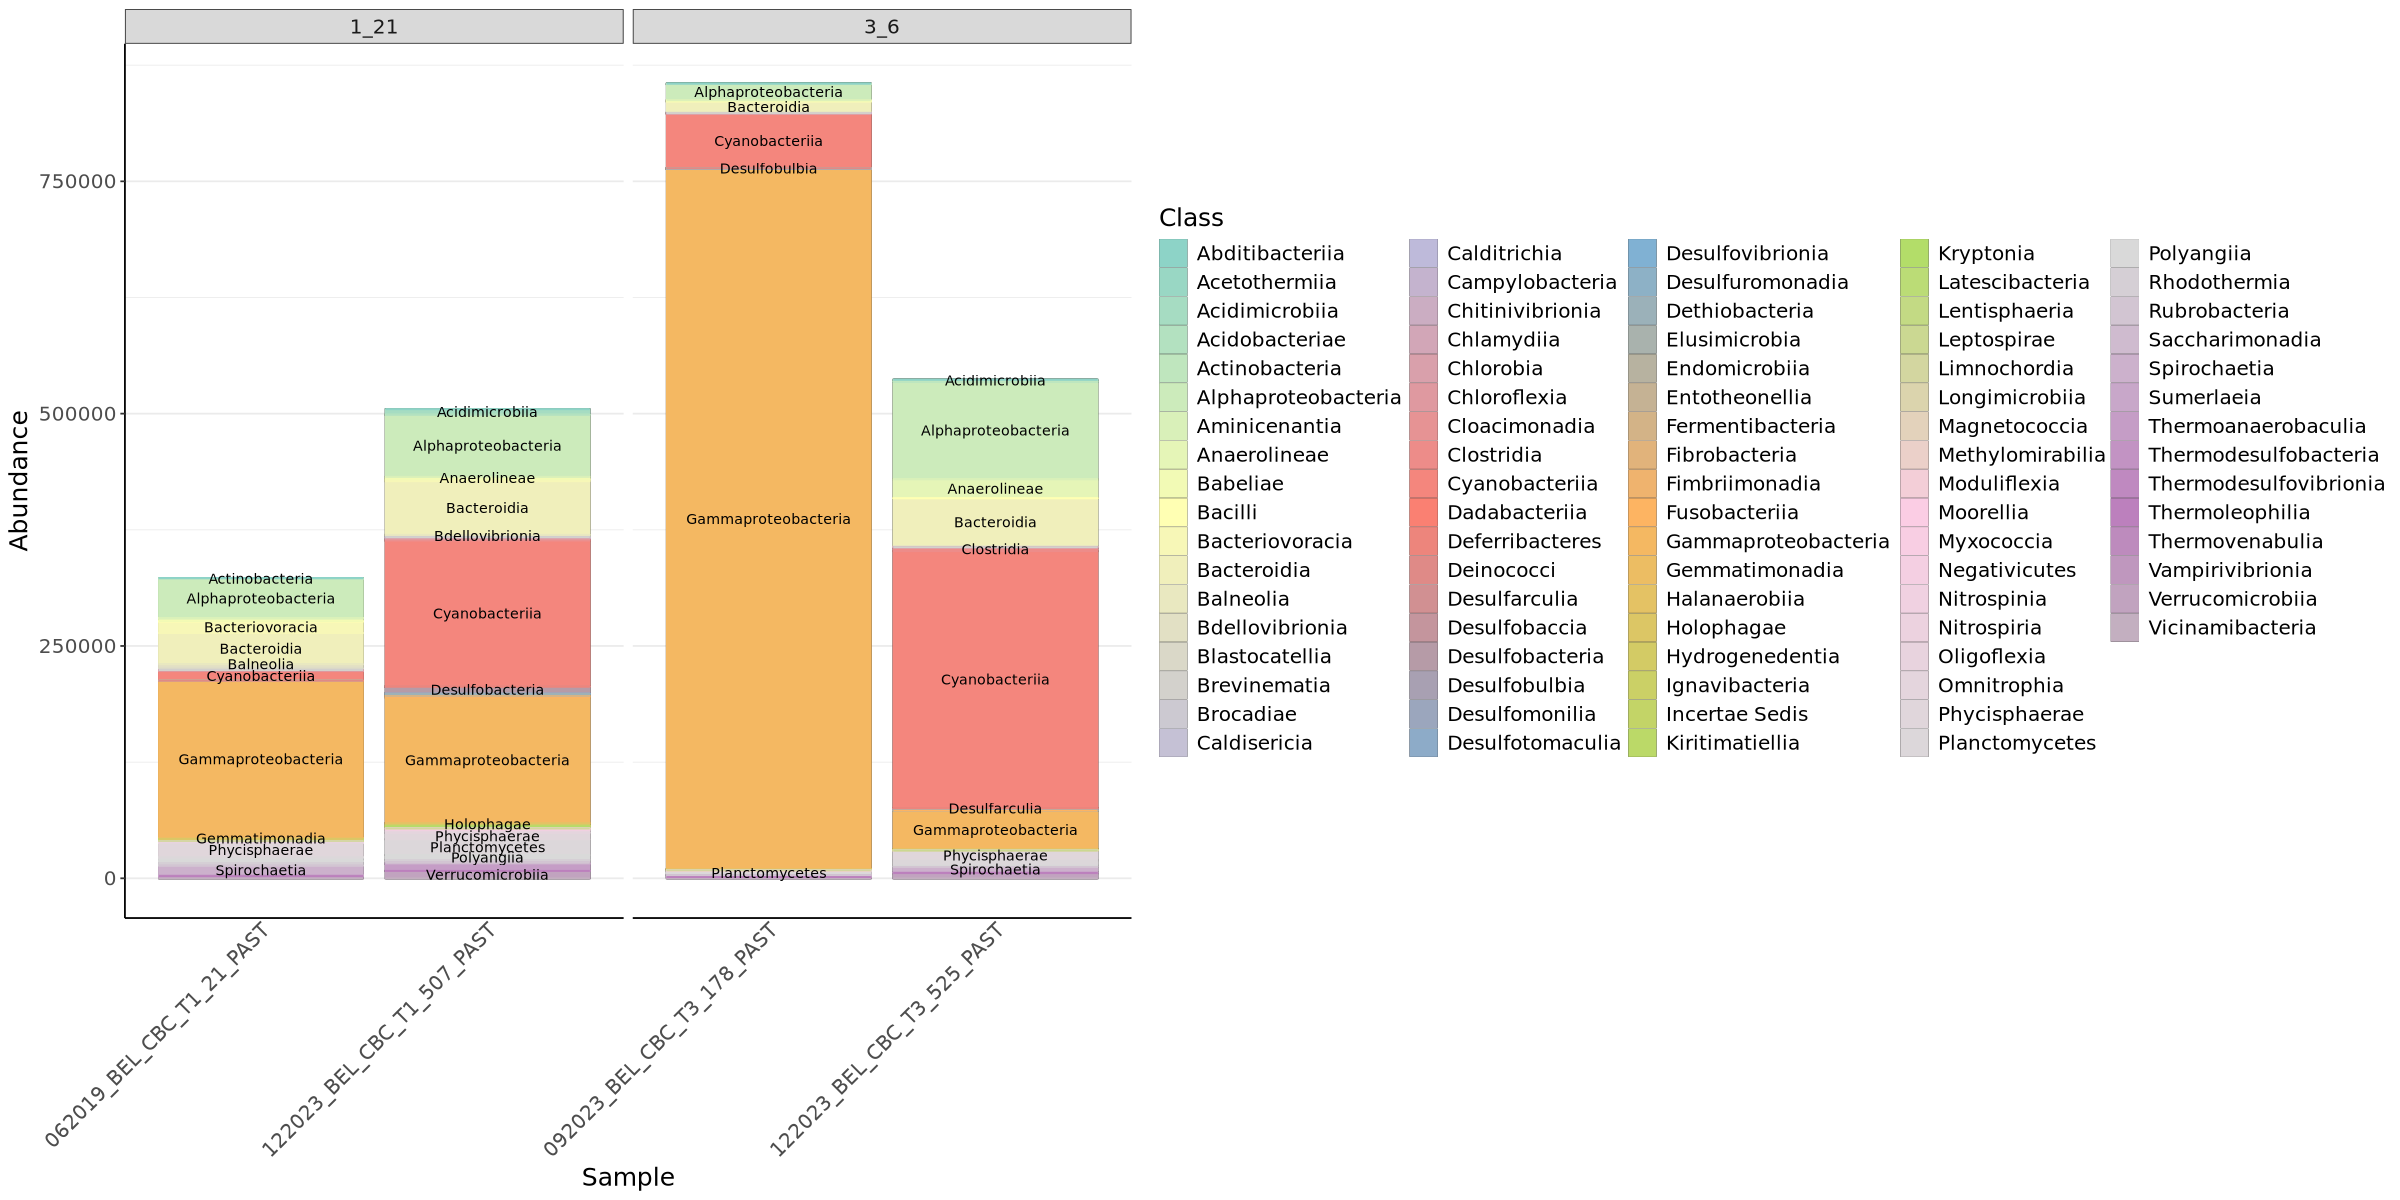

In [40]:
#plot
past <- plot_bar(top100_past, fill = "Class") +
  facet_grid(. ~ colony, scales = "free_x") +
  geom_bar(aes(color = Class, fill = Class), 
           stat = "identity", position = "stack") +
  geom_text(aes(label = Class, fill = Class),
            position = position_stack(vjust = 0.5),
            color = "black", size = 3, check_overlap = TRUE) +
  scale_fill_manual(values = mycolors, drop = TRUE) +
  scale_color_manual(values = mycolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 15)
  )
past

In [41]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/plot_past_class.png", plot = past, width = 20, height = 10, units = "in", dpi = 300)

Warning message in geom_text(aes(label = Class, fill = Class), position = position_stack(vjust = 0.5), :
“Ignoring unknown aesthetics: fill”


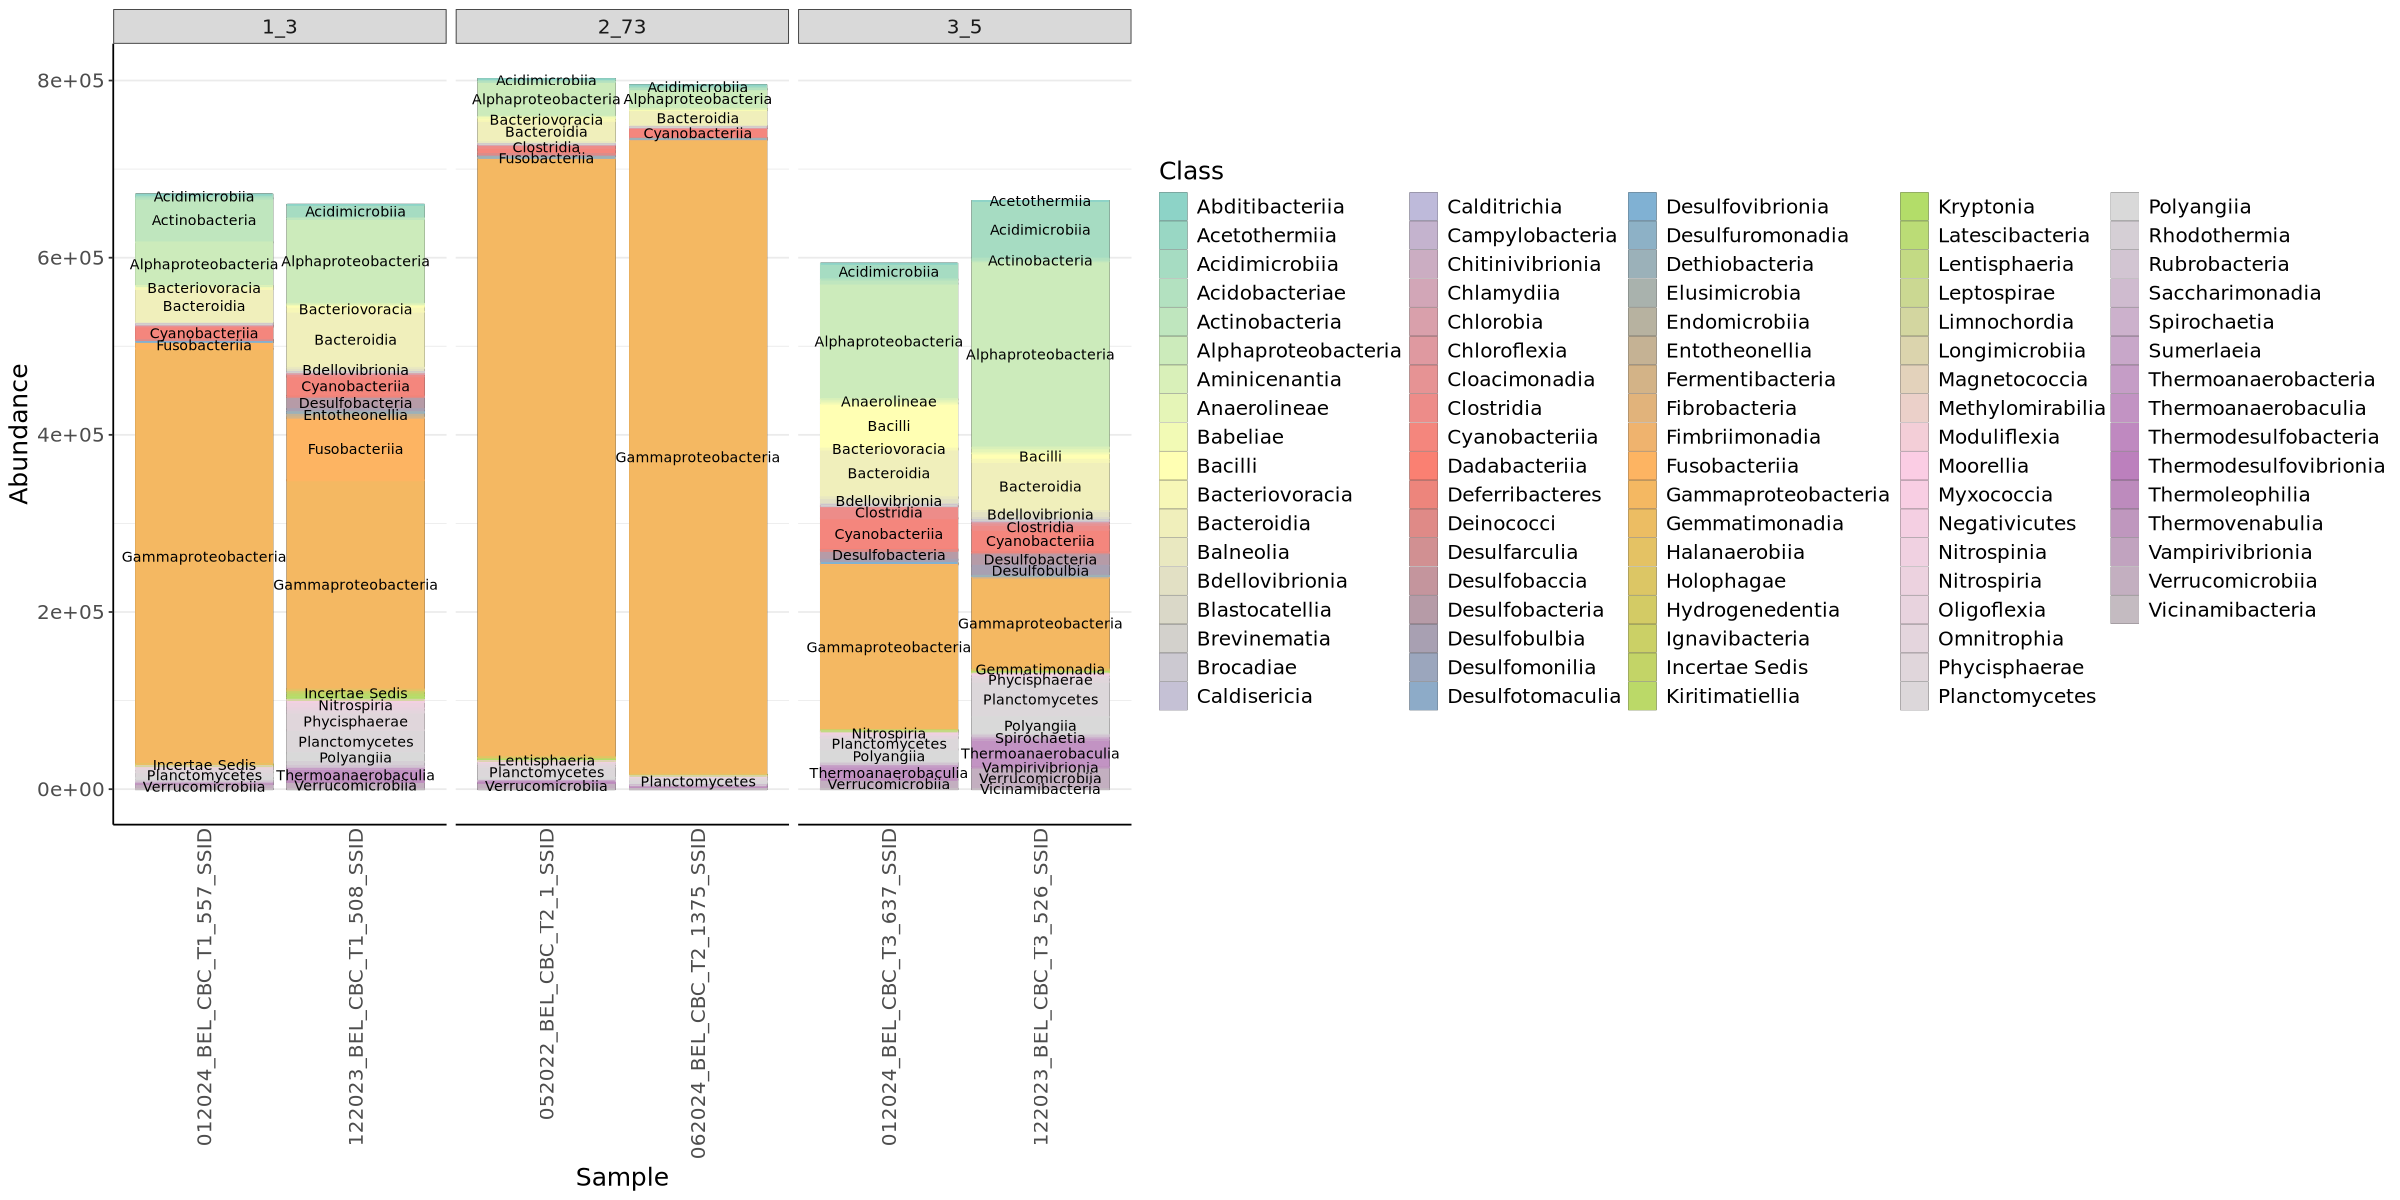

In [75]:
ps_ssid=tax_glom(ps_ssid, taxrank="Class")

top100_ssid <- names(sort(taxa_sums(ps_ssid), decreasing=TRUE))[1:100] 
top100_ssid <- prune_taxa(top100_ssid, ps_ssid) 

#plot
plot_bar(top100_ssid, fill = "Class") +
  facet_grid(. ~ colony, scales = "free_x") +
  geom_bar(aes(color = Class, fill = Class), 
           stat = "identity", position = "stack") +
  geom_text(aes(label = Class, fill = Class),
            position = position_stack(vjust = 0.5),
            color = "black", size = 3, check_overlap = TRUE) +
  scale_fill_manual(values = mycolors, drop = TRUE) +
  scale_color_manual(values = mycolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    text = element_text(size = 15)
  )